<p align="center">
    <img src="https://github.com/YoungsukHan/Hyundai_equip/assets/44924554/076ffad6-abf4-431b-af15-10373ba06182" align="right">
</p>

# ***CNC 머신 시계열 데이터 AI 실습***

**제목:** CNC 머신 품질 예측을 위한 AI 실습  <br>
**Description:** CNC 머신으로부터 수집한 데이터를 전처리하고, 딥러닝 모델을 사용하여 품질 예측을 수행합니다.

본 자료는 정부에서 운영하는 아래의 KAMP(한국인공지능제조플랫폼)의 데이터 및 예제를 수정한 교육자료입니다.

중소벤처기업부, Korea AI Manufacturing Platform(KAMP), CNC 머신 AI 데이터셋, KAIST(울산과학기술원, ㈜이피엠솔루션즈), 2020.12.14., www.kamp-ai.kr

https://www.kamp-ai.kr/aidataDetail?AI_SEARCH=CNC+%EB%A8%B8%EC%8B%A0&page=1&DATASET_SEQ=3&EQUIP_SEL=&GUBUN_SEL=&FILE_TYPE_SEL=&WDATE_SEL=

※ 분석하기에 앞서 다음과 같은 가상환경이 구축되어있는지 확인해주세요. <br>
Python 버전 : 3.10.12

In [96]:
!python --version

Python 3.10.12


## 1. 분석 개요

### 1.1 분석 배경

**공정(설비) 개요:**
- CNC(Computerized Numerical Control) 가공은 컴퓨터 프로그램을 이용하여 기계의 움직임을 제어하는 정밀 가공 공정입니다.
- 주로 금속, 플라스틱, 목재 등 다양한 재료를 가공하는 데 사용되며, 복잡한 형상의 부품을 높은 정밀도로 제작할 수 있습니다.
- 일반적인 CNC 기계에는 선반, 밀링 머신, 드릴링 머신 등이 포함됩니다.

![image](https://github.com/YoungsukHan/Hyundai_equip/assets/44924554/2d412df5-461d-489d-8c2d-5779dd62ad2d)<br>
<center>[용해공정 설비(사진)]</center> <br>

**이슈사항(Pain Point):**
- CNC 절삭공구는 마찰과 절삭력 변화로 마모되거나 파손되어 가공 정밀도가 떨어질 수 있습니다.
- 공정 중 다양한 변수로 인해 품질이 변동되며, 제품 성형 후에야 불량 여부를 확인할 수 있어 일관된 품질 관리가 어렵습니다.

### 1.2 분석 목표

**분석 목표:**
- CNC 설비와 네트워크 연결을 통해 실제 가공생산데이터를 수집하여 공구수명에 따른 가공불량 예측을 딥러닝 알고리즘을 활용하여 해결하고자합니다.

**제조 데이터 분석 기대효과:**
- 데이터 분석을 통해 설비 운영 조건에 따른 생산 품질을 예측하고, 불량률을 낮추기 위한 최적의 운영 조건을 도출합니다.

### 1.3 제조데이터 소개

**데이터 수집 방법:**
- 제조 분야 : 자동차 부품
- 제조 공정명 : 자동차 부품 CNC 가공 공정
- 수집 장비 : 공장 내 CNC 가공 장비 Data, 조건 및 품질 Data 
- 수집 기간 : 5일
- 수집 주기 : 1 sec

**데이터 유형/구조:**<br>
 - 데이터 크기, 데이터 수량: 48개 컬럼, 32,048개의 관측치
 - 데이터 속성 정의 표:<br>
![CNC_1](https://github.com/YoungsukHan/Hyundai_equip/assets/44924554/bb3f6ed9-1943-4895-b5a3-83e26187d1c0)<br>
 - 독립변수/종속변수 정의:<br>
 ![CNC_3](https://github.com/YoungsukHan/Hyundai_equip/assets/44924554/b9cd02c8-ddf0-426a-8031-4bed3a8a45f6)<br>
 ![CNC_4](https://github.com/YoungsukHan/Hyundai_equip/assets/44924554/97af43da-4c2a-49e8-9e99-baf32566a017)

## 2. 분석 실습


### 2-1. 라이브러리 / 데이터 불러오기

#### 필요한 라이브러리 설치 및 불러오기

In [97]:
!pip install --upgrade pip

In [58]:
!pip install tensorflow==2.16.1 pandas==2.2.2 numpy==1.26.4 matplotlib==3.9.0 scikit-learn==1.5.0 imbalanced-learn==0.9.0

In [2]:
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import tensorflow as tf
import random

In [3]:
# 시드 고정
def set_seed(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = "1"
    os.environ['TF_CUDNN_DETERMINISM'] = "1"
    os.environ['PYTHONHASHSEED'] = str(seed)
set_seed()

#### 데이터 불러오기

In [4]:
# CNC 가공 실적 데이터 파일
train_sample = pd.read_csv("./dataset/CNC 비식별화 원본데이터_1209/train.csv", header=0, encoding='utf-8')

# 개별 생산 단위 데이터 파일
path = r'./dataset/CNC 비식별화 원본데이터_1209/CNC Virtual Data set _v2'  # 경로 설정
all_files = glob.glob(os.path.join(path, "*.csv"))

li_df = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li_df.append(df)

df = pd.concat(li_df, axis=0, ignore_index=True)

### 2-2. 데이터 특성 파악


#### 데이터 기본 구조 파악

In [5]:
train_sample.head()

,No,material,feedrate,clamp_pressure,tool_condition,machining_finalized,passed_visual_inspection
0,1,aluminum,6,4.0,unworn,yes,yes
1,2,aluminum,20,4.0,unworn,yes,yes
2,3,aluminum,6,3.0,unworn,yes,yes
3,4,aluminum,6,2.5,unworn,no,NaN
4,5,aluminum,20,3.0,unworn,no,NaN


In [6]:
train_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   No                        25 non-null     int64  
 1   material                  25 non-null     object 
 2   feedrate                  25 non-null     int64  
 3   clamp_pressure            25 non-null     float64
 4   tool_condition            25 non-null     object 
 5   machining_finalized       25 non-null     object 
 6   passed_visual_inspection  19 non-null     object 
dtypes: float64(1), int64(2), object(4)
memory usage: 1.5+ KB


In [7]:
all_files

['./dataset/CNC 비식별화 원본데이터_1209/CNC Virtual Data set _v2\\experiment_01.csv',
 './dataset/CNC 비식별화 원본데이터_1209/CNC Virtual Data set _v2\\experiment_02.csv',
 './dataset/CNC 비식별화 원본데이터_1209/CNC Virtual Data set _v2\\experiment_03.csv',
 './dataset/CNC 비식별화 원본데이터_1209/CNC Virtual Data set _v2\\experiment_04.csv',
 './dataset/CNC 비식별화 원본데이터_1209/CNC Virtual Data set _v2\\experiment_05.csv',
 './dataset/CNC 비식별화 원본데이터_1209/CNC Virtual Data set _v2\\experiment_06.csv',
 './dataset/CNC 비식별화 원본데이터_1209/CNC Virtual Data set _v2\\experiment_07.csv',
 './dataset/CNC 비식별화 원본데이터_1209/CNC Virtual Data set _v2\\experiment_08.csv',
 './dataset/CNC 비식별화 원본데이터_1209/CNC Virtual Data set _v2\\experiment_09.csv',
 './dataset/CNC 비식별화 원본데이터_1209/CNC Virtual Data set _v2\\experiment_10.csv',
 './dataset/CNC 비식별화 원본데이터_1209/CNC Virtual Data set _v2\\experiment_11.csv',
 './dataset/CNC 비식별화 원본데이터_1209/CNC Virtual Data set _v2\\experiment_12.csv',
 './dataset/CNC 비식별화 원본데이터_1209/CNC Virtual Data set _v2\\experi

In [8]:
df.head()

,X_ActualPosition,X_ActualVelocity,X_ActualAcceleration,X_SetPosition,X_SetVelocity,X_SetAcceleration,X_CurrentFeedback,X_DCBusVoltage,X_OutputCurrent,X_OutputVoltage,...,S_CurrentFeedback,S_DCBusVoltage,S_OutputCurrent,S_OutputVoltage,S_OutputPower,S_SystemInertia,M_CURRENT_PROGRAM_NUMBER,M_sequence_number,M_CURRENT_FEEDRATE,Machining_Process
0,202.0,4.0,4.00,202.0,4.0,4.000000,0.18,0.0207,329,2.77,...,0.524,2.740000e-19,329,0.0,6.960000e-07,16.0,1,0,50,Starting
1,202.0,-6.8,-346.00,202.0,-9.6,-354.000000,-10.90,0.1860,328,23.30,...,-0.288,2.740000e-19,328,0.0,-5.270000e-07,16.0,1,4,50,Prep
2,200.0,-13.8,-2.25,200.0,-13.9,3.999905,-8.59,0.1400,328,30.60,...,0.524,2.740000e-19,328,0.0,9.100000e-07,16.0,1,7,50,Prep
3,198.0,-14.0,4.00,198.0,-13.9,3.999905,-6.11,0.1300,327,30.30,...,-0.180,2.740000e-19,328,0.0,1.070000e-06,16.0,1,7,50,Prep
4,197.0,-13.9,-14.80,196.0,-13.9,4.000095,-5.70,0.1140,328,30.50,...,0.226,2.740000e-19,328,0.0,1.960000e-06,16.0,1,7,50,Prep


In [9]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32048 entries, 0 to 32047
Data columns (total 48 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   X_ActualPosition          32048 non-null  float64
 1   X_ActualVelocity          32048 non-null  float64
 2   X_ActualAcceleration      32048 non-null  float64
 3   X_SetPosition             32048 non-null  float64
 4   X_SetVelocity             32048 non-null  float64
 5   X_SetAcceleration         32048 non-null  float64
 6   X_CurrentFeedback         32048 non-null  float64
 7   X_DCBusVoltage            32048 non-null  float64
 8   X_OutputCurrent           32048 non-null  int64  
 9   X_OutputVoltage           32048 non-null  float64
 10  X_OutputPower             32048 non-null  float64
 11  Y_ActualPosition          32048 non-null  float64
 12  Y_ActualVelocity          32048 non-null  float64
 13  Y_ActualAcceleration      32048 non-null  float64
 14  Y_SetP

In [10]:
print(df.describe())

       X_ActualPosition  X_ActualVelocity  X_ActualAcceleration  \
count      32048.000000      32048.000000          32048.000000   
mean         163.805667          3.992182              4.455950   
std           18.461808          5.629767             91.780434   
min          144.000000        -17.300000          -1275.000000   
25%          150.000000          2.330000            -26.300000   
50%          158.000000          4.025000              4.000000   
75%          167.000000          5.175000             30.000000   
max          203.000000         55.300000           1444.000000   

       X_SetPosition  X_SetVelocity  X_SetAcceleration  X_CurrentFeedback  \
count   32048.000000   32048.000000       32048.000000       32048.000000   
mean      163.804013       3.997159           4.435959          -0.477972   
std        18.462444       5.634569          72.012521           4.230802   
min       144.000000     -17.000000        -997.000000         -23.400000   
25%       1

#### 종속변수 별 샘플 수 세기

- machining_finalized = 공정완료 유무<br>
- passed_visual_inspection = 육안검사 통과유무


In [11]:
train_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   No                        25 non-null     int64  
 1   material                  25 non-null     object 
 2   feedrate                  25 non-null     int64  
 3   clamp_pressure            25 non-null     float64
 4   tool_condition            25 non-null     object 
 5   machining_finalized       25 non-null     object 
 6   passed_visual_inspection  19 non-null     object 
dtypes: float64(1), int64(2), object(4)
memory usage: 1.5+ KB


In [12]:
nb_pass = 0
nb_pass_half = 0
nb_defective = 0

train_sample_np = np.array(train_sample.copy())
for i in range(len(train_sample_np)):
    if train_sample_np[i, 5] == 'yes' and train_sample_np[i, 6] == 'yes':
        nb_pass += 1
    elif train_sample_np[i, 5] == 'yes' and train_sample_np[i, 6] == 'no':
        nb_pass_half += 1
    else:
        nb_defective += 1

print(f'공정 완료 및 육안검사 통과: {nb_pass}')
print(f'공정 완료되었으나 육안검사 불합격: {nb_pass_half}')
print(f'공정 미완료: {nb_defective}')
print(f'전체 샘플 개수: {nb_pass + nb_pass_half + nb_defective}')

공정 완료 및 육안검사 통과: 13
공정 완료되었으나 육안검사 불합격: 6
공정 미완료: 6
전체 샘플 개수: 25


### 2-3. 데이터 정제(전처리)


#### CNC 가공 실적 데이터 파일 전처리
- tool_condition 함수: 입력값으로 불러온 ‘train.csv’ 파일을 받고, 출력값으로 각 샘플의 tool_condition에 대해 ‘마모되지않음(unworn)‘ 이면 (0)을, ’마모됨(worn)’ 이면 (1)
- item_inspection 함수: 입력값으로 불러온 ‘train.csv’ 파일을 받고, 출력값으로 각 샘플의 machining_finalized(공정완료)와 passed_visual_inspection(육안검사) 두
가지 항목을 확인하고, 공정완료 및 육안검사 합격(0), 공정완료 및 육안검사 불합격(1), 공정미완료(2)의 3가지 값을 갖는다.

In [13]:
def tool_condition(df):
    df['tool_condition'] = df['tool_condition'].apply(lambda x: 0 if x == 'unworn' else 1)
    return df

def item_inspection(df):
    df['passed_visual_inspection'] = df.apply(
        lambda row: 
            0 if row['machining_finalized'] == 'yes' and row['passed_visual_inspection'] == 'yes'
                else 1 if row['machining_finalized'] == 'yes' and row['passed_visual_inspection'] == 'no'
                    else 2, axis=1)
    return df


In [14]:
train_sample_info = tool_condition(train_sample.copy())
train_sample_info = item_inspection(train_sample_info)
train_sample_info = train_sample_info.drop(columns=['No', 'material', 'machining_finalized'])
train_sample_info = np.array(train_sample_info)

In [15]:
train_sample_info

array([[ 6. ,  4. ,  0. ,  0. ],
       [20. ,  4. ,  0. ,  0. ],
       [ 6. ,  3. ,  0. ,  0. ],
       [ 6. ,  2.5,  0. ,  2. ],
       [20. ,  3. ,  0. ,  2. ],
       [ 6. ,  4. ,  1. ,  1. ],
       [20. ,  4. ,  1. ,  2. ],
       [20. ,  4. ,  1. ,  1. ],
       [15. ,  4. ,  1. ,  1. ],
       [12. ,  4. ,  1. ,  1. ],
       [ 3. ,  4. ,  0. ,  0. ],
       [ 3. ,  3. ,  0. ,  0. ],
       [ 3. ,  4. ,  1. ,  0. ],
       [ 3. ,  3. ,  1. ,  0. ],
       [ 6. ,  3. ,  1. ,  0. ],
       [20. ,  3. ,  1. ,  2. ],
       [ 3. ,  2.5,  0. ,  0. ],
       [ 3. ,  2.5,  1. ,  0. ],
       [15. ,  4. ,  1. ,  1. ],
       [12. ,  4. ,  0. ,  2. ],
       [ 3. ,  4. ,  0. ,  1. ],
       [20. ,  3. ,  1. ,  0. ],
       [ 3. ,  4. ,  1. ,  2. ],
       [ 3. ,  3. ,  0. ,  0. ],
       [ 6. ,  2.5,  1. ,  0. ]])

#### CNC 실적 및 개별 생산 단위 데이터 통합 후 공정 및 육안 검사 상태별 분할
- data_pass : 공정 완료 및 육안검사 통과한 전체 데이터
- data_pass_half : 공정 완료되었으나 육안검사 불합격한 전체 데이터
- data_fail : 공정 미완료한 전체 데이터

In [16]:
k = 0
li_pass = []
li_pass_half = []
li_fail = []

for filename in all_files:
    file_df = pd.read_csv(filename, index_col=None, header=0)

    if train_sample_info[k, 3] == 0:
        li_pass.append(file_df)
    elif train_sample_info[k, 3] == 1:
        li_pass_half.append(file_df)
    else:
        li_fail.append(file_df)
    k+=1

data_pass = pd.concat(li_pass, axis=0, ignore_index=True)
data_pass_half = pd.concat(li_pass_half, axis=0, ignore_index=True)
data_fail = pd.concat(li_fail, axis=0, ignore_index=True)

print(f'공정 완료 및 육안검사 통과한 전체 데이터 수: {len(data_pass)}')
print(f'공정 완료되었으나 육안검사 불합격한 전체 데이터 수 : {len(data_pass_half)}')
print(f'공정 미완료한 전체 데이터 수 : {len(data_fail)}')

공정 완료 및 육안검사 통과한 전체 데이터 수: 22645
공정 완료되었으나 육안검사 불합격한 전체 데이터 수 : 6175
공정 미완료한 전체 데이터 수 : 3228


#### 통합 데이터 전처리
- machining_process 함수: 입력값으로 앞선 두 사용자 함수를 거친 통합 데이터를 받고, 기계의 공정상태(machining_process)를 숫자로 변환한다.

In [17]:
def machining_process(df):
    process_dict = {
        'Prep': 0, 'Layer 1 Up': 1, 'Layer 1 Down': 2, 'Layer 2 Up': 3,
        'Layer 2 Down': 4, 'Layer 3 Up': 5, 'Layer 3 Down': 6,
        'Repositioning': 7, 'End': 8,  'end': 8, 'Starting': 9
    }
    df['Machining_Process'] = df['Machining_Process'].map(process_dict)
    return df

In [18]:
data_pass = machining_process(data_pass)
data_pass_half = machining_process(data_pass_half)
data_fail = machining_process(data_fail)

In [19]:
data_pass['Machining_Process'].value_counts()

Machining_Process
1    3578
7    3299
3    2726
5    2715
2    2516
4    2272
6    2144
8    1740
0    1654
9       1
Name: count, dtype: int64

#### 데이터 라벨링
- 1: 양품
- 0: 불량품

In [20]:
data_pass['Label'] = 1
data_pass_half['Label'] = 0
data_fail['Label'] = 0

#### 훈련/테스트 데이터 분리

In [21]:
data_pass = np.array(data_pass)
data_pass_half = np.array(data_pass_half)
data_fail = np.array(data_fail)

In [22]:
def split_data(data):
    X = data[:, :-1]
    y = data[:, -1:]
    # First, split into train and (validation + test)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
    # Then split (validation + test) into validation and test
    X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    return X_train, X_valid, X_test, y_train, y_valid, y_test

In [23]:
X_train_pass, X_valid_pass, X_test_pass, y_train_pass, y_valid_pass, y_test_pass = split_data(data_pass)
X_train_pass_half, X_valid_pass_half, X_test_pass_half, y_train_pass_half, y_valid_pass_half, y_test_pass_half = split_data(data_pass_half)
X_train_fail, X_valid_fail, X_test_fail, y_train_fail, y_valid_fail, y_test_fail = split_data(data_fail)

In [24]:
X_train = np.concatenate((X_train_pass, X_train_pass_half, X_train_fail), axis=0)
y_train = np.concatenate((y_train_pass, y_train_pass_half, y_train_fail), axis=0)
X_valid = np.concatenate((X_valid_pass, X_valid_pass_half, X_valid_fail), axis=0)
y_valid = np.concatenate((y_valid_pass, y_valid_pass_half, y_valid_fail), axis=0)
X_test = np.concatenate((X_test_pass, X_test_pass_half, X_test_fail), axis=0)
y_test = np.concatenate((y_test_pass, y_test_pass_half, y_test_fail), axis=0)

#### 정규화

Min-max normalization는 데이터를 0과 1 사이의 값으로 scaling합니다.

1) data의 최대값(max)과 최소값(min)을 구한다.
2) 정규화할 데이터 값(x)과 앞서 구한 최대값(Xmax), 최소값(Xmin)을 다음의 식에 대입한다.<br>

<img src="https://github.com/YoungsukHan/Hyundai_equip/assets/44924554/c5a29097-0eb4-44a5-b379-2ea9df771095" width="400" height="400"/>

In [25]:
scarler = MinMaxScaler()
X_train = scarler.fit_transform(X_train)
X_valid = scarler.fit_transform(X_valid)
X_test = scarler.fit_transform(X_test)

### 2-4. 모델 구축 및 훈련


**심층 신경망(DNN)**
- 심층 신경망(Deep Neural Network)은 여러 층의 노드로 구성된 신경망 구조를 쌓아 학습시키는 AI 알고리즘입니다.

    |<b>DNN의 기본구조</b> |
    | :--: |
    | ![](https://parallelr.com/uploads/2016/02/dnn_architecture.png)|
    | (출처:https://parallelr.com/2016/02/13/r-deep-neural-network-from-scratch/)|

  
- 각 노드는 입력 데이터를 받아 연산 후 결과를 출력하며, 활성화 함수(예: 시그모이드, ReLU)를 통해 비선형 변환을 수행합니다.

    |<b>활성화 함수 예: ReLU, sigmoid</b> |
    | :--: |
    | ![CNC_5](https://github.com/YoungsukHan/Hyundai_equip/assets/44924554/19863edd-d7a5-4d73-8462-cd238e520c82)|

- 학습은 경사 하강법을 통해 손실함수(loss function)를 최소화하는 방향으로 진행되며, 분류 문제에서는 주로 이진 교차 엔트로피(binary crossentropy)를 사용합니다.

    |<b>이진 교차 엔트로피(binary crossentropy)</b> |
    | :--: |
    | ![CNC_6](https://github.com/YoungsukHan/Hyundai_equip/assets/44924554/e73cdb2d-da9f-49e9-a414-d364a87bff2c)|



### DNN 모델 구축

In [26]:
set_seed()

batch_size = 1024
epochs = 30

model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [27]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,201 (12.50 KB)

 Trainable params: 3,201 (12.50 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
X_train.shape[1]

48

#### 모델 학습

In [29]:
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_valid, y_valid))

Epoch 1/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5515 - loss: 0.6690 - val_accuracy: 0.7066 - val_loss: 0.5546
Epoch 2/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7014 - loss: 0.5480 - val_accuracy: 0.7370 - val_loss: 0.5302
Epoch 3/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7342 - loss: 0.5250 - val_accuracy: 0.7348 - val_loss: 0.5162
Epoch 4/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7434 - loss: 0.5111 - val_accuracy: 0.7488 - val_loss: 0.5017
Epoch 5/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7520 - loss: 0.4965 - val_accuracy: 0.7566 - val_loss: 0.4870
Epoch 6/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7604 - loss: 0.4813 - val_accuracy: 0.7557 - val_loss: 0.4718
Epoch 7/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7613 - loss: 0.4659 - val_accuracy: 0.7607 - val_loss: 0.4571
Epoch 8/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7650 - loss: 0.4512 - val_accuracy: 0.7704 - val_loss

#### 손실 그래프 시각화

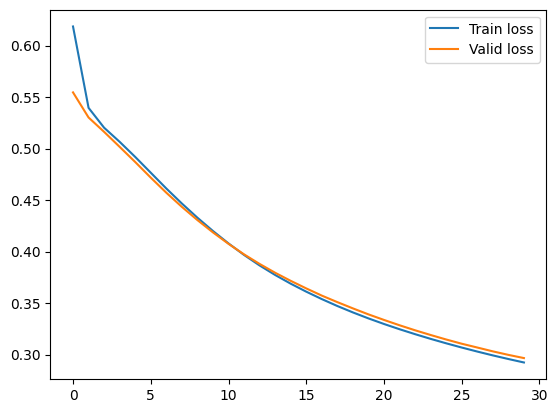

In [30]:
plt.figure()
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Valid loss')
plt.legend()
plt.show()

### 2-5. 모델 평가


In [31]:
y_pred = model.predict(X_test)
y_pred_class = (y_pred > 0.5).astype("int32")

print(classification_report(y_test, y_pred_class))

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step
              precision    recall  f1-score   support

         0.0       0.78      0.74      0.76      1881
         1.0       0.89      0.91      0.90      4529

    accuracy                           0.86      6410
   macro avg       0.84      0.83      0.83      6410
weighted avg       0.86      0.86      0.86      6410



In [32]:
accuracy = accuracy_score(y_test, y_pred_class)
f1 = f1_score(y_test, y_pred_class)

print(f'Accuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')

init_accuracy = accuracy
init_f1 = f1

Accuracy: 0.8624
F1 Score: 0.9037


### 모델링 수정 - 레이어 구조 변경(레이어 추가)

Epoch 1/30


c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6601 - loss: 0.6026 - val_accuracy: 0.7463 - val_loss: 0.5079
Epoch 2/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7610 - loss: 0.4831 - val_accuracy: 0.8090 - val_loss: 0.4143
Epoch 3/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8092 - loss: 0.3891 - val_accuracy: 0.8384 - val_loss: 0.3471
Epoch 4/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8476 - loss: 0.3318 - val_accuracy: 0.8523 - val_loss: 0.3086
Epoch 5/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8663 - loss: 0.2956 - val_accuracy: 0.8755 - val_loss: 0.2742
Epoch 6/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8823 - loss: 0.2600 - val_accuracy: 0.8955 - val_loss: 0.2404
Epoch 7/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9005 - loss: 0.2285 - val_accuracy: 0.9053 - val_loss: 0.2242
Epoch 8/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9135 - loss: 0.2039 - val_accuracy: 0.9128 - val_loss: 0.2017
Ep

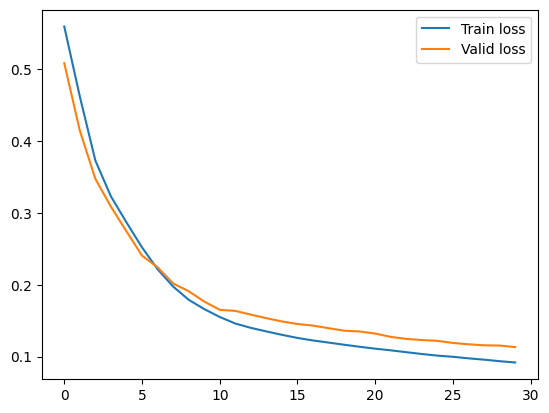

초기 Accuracy: 0.8624
초기 F1 Score: 0.9037
변경 후 Accuracy: 0.9560
변경 후 F1 Score: 0.9689


In [33]:
set_seed()

batch_size = 1024
epochs = 30

model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_valid, y_valid))

y_pred = model.predict(X_test)
y_pred_class = (y_pred > 0.5).astype("int32")

plt.figure()
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Valid loss')
plt.legend()
plt.show()

accuracy = accuracy_score(y_test, y_pred_class)
f1 = f1_score(y_test, y_pred_class)

print(f'초기 Accuracy: {init_accuracy:.4f}')
print(f'초기 F1 Score: {init_f1:.4f}')
print(f'변경 후 Accuracy: {accuracy:.4f}')
print(f'변경 후 F1 Score: {f1:.4f}')

### 모델링 수정 - Activation 함수 변경

Epoch 1/30


c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7021 - loss: 0.6127 - val_accuracy: 0.7066 - val_loss: 0.5842
Epoch 2/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7021 - loss: 0.5814 - val_accuracy: 0.7066 - val_loss: 0.5635
Epoch 3/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7020 - loss: 0.5614 - val_accuracy: 0.6992 - val_loss: 0.5499
Epoch 4/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7022 - loss: 0.5480 - val_accuracy: 0.7058 - val_loss: 0.5406
Epoch 5/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7047 - loss: 0.5388 - val_accuracy: 0.7048 - val_loss: 0.5336
Epoch 6/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7053 - loss: 0.5316 - val_accuracy: 0.7073 - val_loss: 0.5275
Epoch 7/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7082 - loss: 0.5254 - val_accuracy: 0.7106 - val_loss: 0.5217
Epoch 8/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7096 - loss: 0.5195 - val_accuracy: 0.7126 - val_loss: 0.5158
Epo

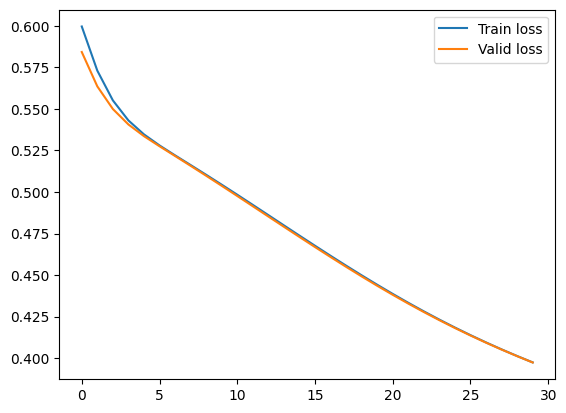

초기 Accuracy: 0.8624
초기 F1 Score: 0.9037
변경 후 Accuracy: 0.7994
변경 후 F1 Score: 0.8656


In [91]:
set_seed()

batch_size = 1024
epochs = 30

model = Sequential()
model.add(Dense(64, activation='sigmoid', input_shape=(X_train.shape[1],))) #Relu -> Sigmoid 변경
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_valid, y_valid))

y_pred = model.predict(X_test)
y_pred_class = (y_pred > 0.5).astype("int32")

plt.figure()
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Valid loss')
plt.legend()
plt.show()

accuracy = accuracy_score(y_test, y_pred_class)
f1 = f1_score(y_test, y_pred_class)

print(f'초기 Accuracy: {init_accuracy:.4f}')
print(f'초기 F1 Score: {init_f1:.4f}')
print(f'변경 후 Accuracy: {accuracy:.4f}')
print(f'변경 후 F1 Score: {f1:.4f}')

### 모델링 수정 - 드롭아웃 추가

Epoch 1/30


c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7207 - loss: 0.5877 - val_accuracy: 0.7047 - val_loss: 0.5472
Epoch 2/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7100 - loss: 0.5423 - val_accuracy: 0.7211 - val_loss: 0.5297
Epoch 3/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7232 - loss: 0.5254 - val_accuracy: 0.7257 - val_loss: 0.5148
Epoch 4/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7347 - loss: 0.5104 - val_accuracy: 0.7373 - val_loss: 0.4998
Epoch 5/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7421 - loss: 0.4955 - val_accuracy: 0.7418 - val_loss: 0.4834
Epoch 6/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7497 - loss: 0.4802 - val_accuracy: 0.7544 - val_loss: 0.4670
Epoch 7/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7605 - loss: 0.4648 - val_accuracy: 0.7754 - val_loss: 0.4519
Epoch 8/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7715 - loss: 0.4483 - val_accuracy: 0.7872 - val_loss: 0.4375
Ep

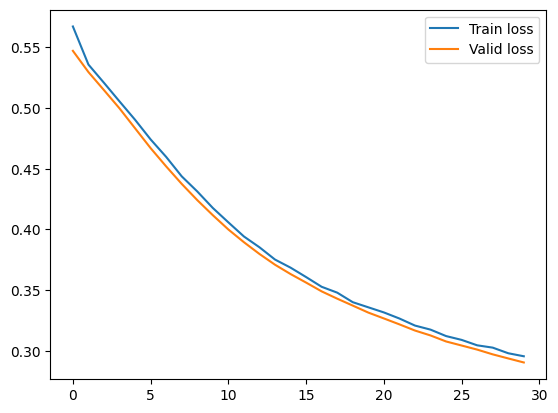

초기 Accuracy: 0.8624
초기 F1 Score: 0.9037
변경 후 Accuracy: 0.8718
변경 후 F1 Score: 0.9101


In [92]:
set_seed()

batch_size = 1024
epochs = 30

model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_valid, y_valid))

y_pred = model.predict(X_test)
y_pred_class = (y_pred > 0.5).astype("int32")

plt.figure()
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Valid loss')
plt.legend()
plt.show()

accuracy = accuracy_score(y_test, y_pred_class)
f1 = f1_score(y_test, y_pred_class)

print(f'초기 Accuracy: {init_accuracy:.4f}')
print(f'초기 F1 Score: {init_f1:.4f}')
print(f'변경 후 Accuracy: {accuracy:.4f}')
print(f'변경 후 F1 Score: {f1:.4f}')

### 모델링 수정 - 배치사이즈 조정(증가)

Epoch 1/30


c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.3701 - loss: 0.7329 - val_accuracy: 0.6307 - val_loss: 0.6675
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6729 - loss: 0.6521 - val_accuracy: 0.7080 - val_loss: 0.6096
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7060 - loss: 0.6004 - val_accuracy: 0.7067 - val_loss: 0.5771
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7045 - loss: 0.5721 - val_accuracy: 0.7066 - val_loss: 0.5614
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7045 - loss: 0.5585 - val_accuracy: 0.7066 - val_loss: 0.5538
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7045 - loss: 0.5512 - val_accuracy: 0.7066 - val_loss: 0.5478
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7045 - loss: 0.5448 - val_accuracy: 0.7066 - val_loss: 0.5417
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7046 - loss: 0.5381 - val_accuracy: 0.6878 - val_loss: 0.5358
Epoch 9/30


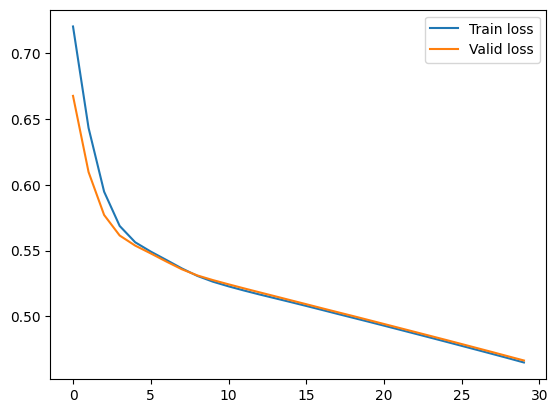

초기 Accuracy: 0.8624
초기 F1 Score: 0.9037
변경 후 Accuracy: 0.7685
변경 후 F1 Score: 0.8444


In [93]:
set_seed()

batch_size = 5000 # 1024 -> 5000
epochs = 30

model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_valid, y_valid))

y_pred = model.predict(X_test)
y_pred_class = (y_pred > 0.5).astype("int32")

plt.figure()
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Valid loss')
plt.legend()
plt.show()

accuracy = accuracy_score(y_test, y_pred_class)
f1 = f1_score(y_test, y_pred_class)

print(f'초기 Accuracy: {init_accuracy:.4f}')
print(f'초기 F1 Score: {init_f1:.4f}')
print(f'변경 후 Accuracy: {accuracy:.4f}')
print(f'변경 후 F1 Score: {f1:.4f}')

### 모델링 수정 - 배치사이즈 조정(감소)

Epoch 1/30


c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6049 - loss: 0.6311 - val_accuracy: 0.7304 - val_loss: 0.5305
Epoch 2/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7350 - loss: 0.5224 - val_accuracy: 0.7471 - val_loss: 0.5034
Epoch 3/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7534 - loss: 0.4955 - val_accuracy: 0.7468 - val_loss: 0.4764
Epoch 4/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7613 - loss: 0.4678 - val_accuracy: 0.7613 - val_loss: 0.4495
Epoch 5/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7698 - loss: 0.4412 - val_accuracy: 0.7788 - val_loss: 0.4259
Epoch 6/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7834 - loss: 0.4180 - val_accuracy: 0.7961 - val_loss: 0.4056
Epoch 7/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7991 - loss: 0.3978 - val_accuracy: 0.8094 - val_loss: 0.3883
Epoch 8/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8127 - loss: 0.3807 - val_accuracy: 0.8165 - val_loss: 0.3735
Epo

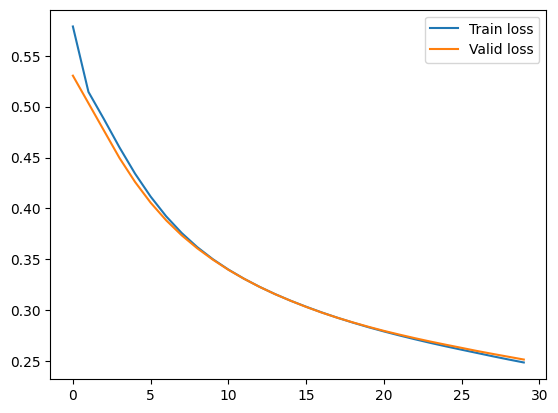

초기 Accuracy: 0.8624
초기 F1 Score: 0.9037
변경 후 Accuracy: 0.8847
변경 후 F1 Score: 0.9191


In [94]:
set_seed()

batch_size = 512 # 1024 -> 512
epochs = 30

model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_valid, y_valid))

y_pred = model.predict(X_test)
y_pred_class = (y_pred > 0.5).astype("int32")

plt.figure()
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Valid loss')
plt.legend()
plt.show()

accuracy = accuracy_score(y_test, y_pred_class)
f1 = f1_score(y_test, y_pred_class)

print(f'초기 Accuracy: {init_accuracy:.4f}')
print(f'초기 F1 Score: {init_f1:.4f}')
print(f'변경 후 Accuracy: {accuracy:.4f}')
print(f'변경 후 F1 Score: {f1:.4f}')

### 모델링 수정 - 클래스 불균형 보완

#### 클래스 불균형 문제 해결(SMOTE)
- SMOTE(Synthetic Minority Over-sampling Technique)는 불균형 데이터셋에서 소수 클래스의 데이터를 증가시켜 데이터 균형을 맞추는 오버샘플링 기법입니다.

    |<b>SMOTE 작동방식</b> |
    | :--: |
    | ![](https://miro.medium.com/v2/resize:fit:720/format:webp/1*CeOd_Wbn7O6kpjSTKTIUog.png)|
    | 출처:https://medium.com/@parthdholakiya180/smote-synthetic-minority-over-sampling-technique-4d5a5d69d720|


In [99]:
!pip install imbalanced-learn==0.9.0

In [37]:
set_seed()

from imblearn.over_sampling import SMOTE

sm = SMOTE()
X_res, y_res = sm.fit_resample(X_train, y_train)

In [38]:
unique, counts = np.unique(y_train, return_counts=True)
print(unique)
print(counts)

[0. 1.]
[ 5641 13587]


In [39]:
pd.Series(y_res).value_counts()

1.0    13587
0.0    13587
Name: count, dtype: int64

Epoch 1/30


c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6194 - loss: 0.6625 - val_accuracy: 0.7334 - val_loss: 0.5967
Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6953 - loss: 0.5920 - val_accuracy: 0.7417 - val_loss: 0.5685
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7212 - loss: 0.5608 - val_accuracy: 0.7585 - val_loss: 0.5509
Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7505 - loss: 0.5325 - val_accuracy: 0.7739 - val_loss: 0.5271
Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7769 - loss: 0.5050 - val_accuracy: 0.7788 - val_loss: 0.5087
Epoch 6/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7930 - loss: 0.4783 - val_accuracy: 0.7856 - val_loss: 0.4925
Epoch 7/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8066 - loss: 0.4542 - val_accuracy: 0.7938 - val_loss: 0.4776
Epoch 8/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8184 - loss: 0.4329 - val_accuracy: 0.8064 - val_loss: 0.4644
Epo

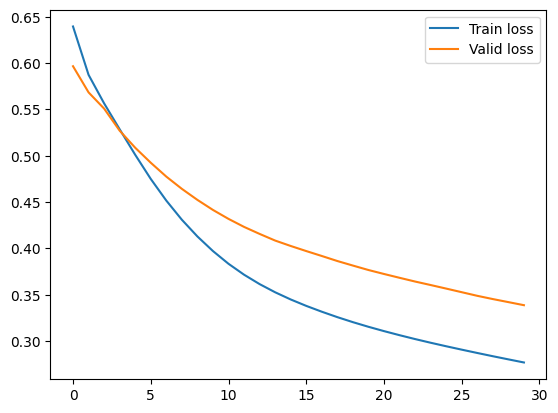

초기 Accuracy: 0.8624
초기 F1 Score: 0.9037
변경 후 Accuracy: 0.8928
변경 후 F1 Score: 0.9193


In [40]:
set_seed()

batch_size = 1024
epochs = 30

model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_res, y_res, epochs=epochs, batch_size=batch_size, validation_data=(X_valid, y_valid))

y_pred = model.predict(X_test)
y_pred_class = (y_pred > 0.5).astype("int32")

plt.figure()
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Valid loss')
plt.legend()
plt.show()

accuracy = accuracy_score(y_test, y_pred_class)
f1 = f1_score(y_test, y_pred_class)

print(f'초기 Accuracy: {init_accuracy:.4f}')
print(f'초기 F1 Score: {init_f1:.4f}')
print(f'변경 후 Accuracy: {accuracy:.4f}')
print(f'변경 후 F1 Score: {f1:.4f}')

### 최종 모델링

Epoch 1/30


C:\Users\Han\Miniconda3\envs\hyundai_equip_6\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6996 - loss: 0.5880 - val_accuracy: 0.8179 - val_loss: 0.4126
Epoch 2/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8542 - loss: 0.3779 - val_accuracy: 0.8800 - val_loss: 0.3344
Epoch 3/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8817 - loss: 0.3108 - val_accuracy: 0.8860 - val_loss: 0.2972
Epoch 4/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9013 - loss: 0.2633 - val_accuracy: 0.8924 - val_loss: 0.2438
Epoch 5/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9120 - loss: 0.2298 - val_accuracy: 0.9086 - val_loss: 0.2193
Epoch 6/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9221 - loss: 0.2028 - val_accuracy: 0.9051 - val_loss: 0.2128
Epoch 7/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9286 - loss: 0.1811 - val_accuracy: 0.9120 - val_loss: 0.2031
Epoch 8/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9315 - loss: 0.1699 - val_accuracy: 0.9176 - val_loss: 0.1846
Epo

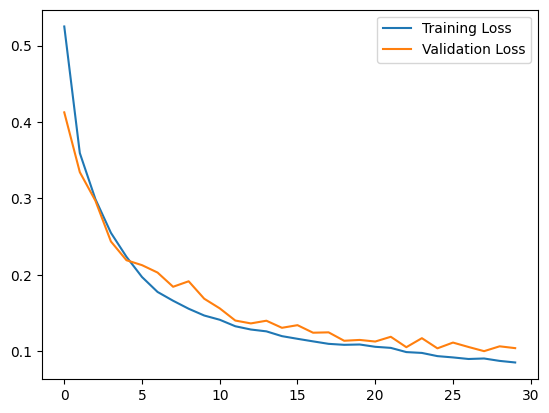

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step
초기 모델 Accuracy: 0.8624
초기 모델 F1 Score: 0.8613
변경 후 Accuracy: 0.9633
변경 후 F1 Score: 0.9637


In [254]:
set_seed()

batch_size = 1024
epochs = 100

model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_res, y_res, epochs=epochs, batch_size=batch_size, validation_data=(X_valid, y_valid))

y_pred = model.predict(X_test)
y_pred_class = (y_pred > 0.5).astype("int32")

plt.figure()
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Valid loss')
plt.legend()
plt.show()

accuracy = accuracy_score(y_test, y_pred_class)
f1 = f1_score(y_test, y_pred_class)

print(f'초기 Accuracy: {init_accuracy:.4f}')
print(f'초기 F1 Score: {init_f1:.4f}')
print(f'변경 후 Accuracy: {accuracy:.4f}')
print(f'변경 후 F1 Score: {f1:.4f}')

In [43]:
!pip install scikeras

In [44]:
def create_model(dropout_rate=0.1, activation='relu'):
    model = Sequential()
    model.add(Dense(256, activation=activation, input_shape=(X_train.shape[1],)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(128, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [45]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

set_seed()

batch_size = 1024
epochs = 30
dropout_rate = 0.1
activation = 'relu'

X_train_full = np.concatenate((X_train, X_valid), axis=0)
y_train_full = np.concatenate((y_train, y_valid), axis=0)

model = KerasClassifier(build_fn=create_model, dropout_rate=dropout_rate, activation=activation, epochs=epochs, batch_size=batch_size)

param_grid = {
    'dropout_rate': [0.0, 0.1, 0.2, 0.5],
    'activation': ['relu', 'sigmoid', 'tanh'],
    'batch_size': [1024, 5000]
}

grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid_result = grid.fit(X_train_full, y_train_full)

Epoch 1/30


c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6393 - loss: 0.6102
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7451 - loss: 0.4947
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7722 - loss: 0.4431
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7961 - loss: 0.3955
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8173 - loss: 0.3646
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8317 - loss: 0.3427
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8455 - loss: 0.3249
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8564 - loss: 0.3080
Epoch 9/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8643 - loss: 0.2897
Epoch 10/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8763 - loss: 0.2698
Epoch 11/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8854 - loss: 0.2499
Epoch 12/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8954 - loss: 0.2330


c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7231 - loss: 0.5559 
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7639 - loss: 0.4661
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7818 - loss: 0.4141
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8008 - loss: 0.3779
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8230 - loss: 0.3489
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8396 - loss: 0.3229 
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8590 - loss: 0.2943
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8694 - loss: 0.2709
Epoch 9/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8808 - loss: 0.2512
Epoch 10/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8900 - loss: 0.2338
Epoch 11/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8983 - loss: 0.2174
Epoch 12/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9057 - loss: 0.202

c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6374 - loss: 0.6025
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7445 - loss: 0.4888
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7765 - loss: 0.4242
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7966 - loss: 0.3887
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8119 - loss: 0.3631
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8267 - loss: 0.3407
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8429 - loss: 0.3209
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8536 - loss: 0.3027
Epoch 9/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8620 - loss: 0.2847
Epoch 10/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8722 - loss: 0.2653
Epoch 11/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8840 - loss: 0.2456
Epoch 12/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8928 - loss: 0.2283


c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6652 - loss: 0.5930
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7578 - loss: 0.4827
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7959 - loss: 0.4161
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8243 - loss: 0.3700
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8467 - loss: 0.3303
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8602 - loss: 0.3042
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8716 - loss: 0.2824
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8807 - loss: 0.2630
Epoch 9/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8899 - loss: 0.2459
Epoch 10/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8963 - loss: 0.2305
Epoch 11/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9025 - loss: 0.2167
Epoch 12/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9080 - loss: 0.2041


c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6404 - loss: 0.6109 
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7517 - loss: 0.4942
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7910 - loss: 0.4307
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8140 - loss: 0.3802
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8358 - loss: 0.3399
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8509 - loss: 0.3144
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8616 - loss: 0.2931
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8726 - loss: 0.2733
Epoch 9/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8800 - loss: 0.2559
Epoch 10/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8876 - loss: 0.2415
Epoch 11/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8943 - loss: 0.2282
Epoch 12/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9000 - loss: 0.2153

c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6761 - loss: 0.5854
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7433 - loss: 0.4819
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7776 - loss: 0.4231
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7966 - loss: 0.3896
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8184 - loss: 0.3617
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8322 - loss: 0.3437
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8414 - loss: 0.3256
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8513 - loss: 0.3094 
Epoch 9/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8629 - loss: 0.2915
Epoch 10/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8726 - loss: 0.2731
Epoch 11/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8786 - loss: 0.2557
Epoch 12/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8879 - loss: 0.2395

c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7126 - loss: 0.5771
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7536 - loss: 0.4697
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7866 - loss: 0.4073
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8085 - loss: 0.3735
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8288 - loss: 0.3436
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8511 - loss: 0.3165 
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8622 - loss: 0.2907
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8714 - loss: 0.2696
Epoch 9/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8804 - loss: 0.2534
Epoch 10/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8891 - loss: 0.2369
Epoch 11/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8965 - loss: 0.2208
Epoch 12/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9032 - loss: 0.2068

c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6807 - loss: 0.5897
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7404 - loss: 0.4850
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7692 - loss: 0.4284
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7966 - loss: 0.3866
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8174 - loss: 0.3588
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8318 - loss: 0.3362
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8416 - loss: 0.3195
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8561 - loss: 0.2978
Epoch 9/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8705 - loss: 0.2745
Epoch 10/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8807 - loss: 0.2560
Epoch 11/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8877 - loss: 0.2402
Epoch 12/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8937 - loss: 0.2236


c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6913 - loss: 0.5870 
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7531 - loss: 0.4799
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7911 - loss: 0.4178
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8208 - loss: 0.3690
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8396 - loss: 0.3327
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8590 - loss: 0.3062
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8728 - loss: 0.2832
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8830 - loss: 0.2630
Epoch 9/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8903 - loss: 0.2441
Epoch 10/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8941 - loss: 0.2334
Epoch 11/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8993 - loss: 0.2193
Epoch 12/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9026 - loss: 0.2108

c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6314 - loss: 0.6120
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7501 - loss: 0.4983
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7845 - loss: 0.4296
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8142 - loss: 0.3766
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8343 - loss: 0.3413
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8506 - loss: 0.3129
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8605 - loss: 0.2935
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8685 - loss: 0.2760
Epoch 9/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8769 - loss: 0.2579
Epoch 10/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8831 - loss: 0.2464 
Epoch 11/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8882 - loss: 0.2346
Epoch 12/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8941 - loss: 0.2192

c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6872 - loss: 0.5884
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7449 - loss: 0.4763
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7747 - loss: 0.4208
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8003 - loss: 0.3822
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8201 - loss: 0.3561 
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8335 - loss: 0.3346
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8497 - loss: 0.3138
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8570 - loss: 0.2968
Epoch 9/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8682 - loss: 0.2806
Epoch 10/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8768 - loss: 0.2587
Epoch 11/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8861 - loss: 0.2453
Epoch 12/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8935 - loss: 0.2268

c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6703 - loss: 0.5995
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7432 - loss: 0.5011
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7677 - loss: 0.4441
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7930 - loss: 0.3986
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8129 - loss: 0.3683
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8314 - loss: 0.3408
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8501 - loss: 0.3136
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8613 - loss: 0.2932
Epoch 9/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8696 - loss: 0.2729
Epoch 10/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8789 - loss: 0.2548
Epoch 11/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8881 - loss: 0.2368
Epoch 12/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8955 - loss: 0.2254


c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6838 - loss: 0.5880
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7379 - loss: 0.4893
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7758 - loss: 0.4217
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7969 - loss: 0.3794
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8137 - loss: 0.3588
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8292 - loss: 0.3350
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8423 - loss: 0.3173
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8476 - loss: 0.3045
Epoch 9/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8592 - loss: 0.2872
Epoch 10/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8673 - loss: 0.2734
Epoch 11/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8722 - loss: 0.2636
Epoch 12/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8782 - loss: 0.2485


c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6620 - loss: 0.5984
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7490 - loss: 0.4984
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7896 - loss: 0.4357
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8126 - loss: 0.3894
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8287 - loss: 0.3522
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8489 - loss: 0.3243
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8593 - loss: 0.3012
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8689 - loss: 0.2783
Epoch 9/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8806 - loss: 0.2652
Epoch 10/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8876 - loss: 0.2434
Epoch 11/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8924 - loss: 0.2343
Epoch 12/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8996 - loss: 0.2201


c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6778 - loss: 0.5919
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7461 - loss: 0.4931
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7811 - loss: 0.4240
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8086 - loss: 0.3813
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8327 - loss: 0.3428
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8448 - loss: 0.3195
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8630 - loss: 0.2881
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8733 - loss: 0.2713
Epoch 9/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8836 - loss: 0.2517
Epoch 10/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8949 - loss: 0.2292
Epoch 11/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8988 - loss: 0.2187
Epoch 12/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9041 - loss: 0.2077


c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6168 - loss: 0.6381
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7441 - loss: 0.5134
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7530 - loss: 0.4732
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7821 - loss: 0.4264
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7951 - loss: 0.3947
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8137 - loss: 0.3658
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8232 - loss: 0.3477
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8398 - loss: 0.3276
Epoch 9/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8469 - loss: 0.3153
Epoch 10/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8554 - loss: 0.2984
Epoch 11/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8590 - loss: 0.2851
Epoch 12/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8678 - loss: 0.2711


c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6614 - loss: 0.6131 
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7359 - loss: 0.5130
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7525 - loss: 0.4695
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7802 - loss: 0.4215
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7971 - loss: 0.3888
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8145 - loss: 0.3651
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8339 - loss: 0.3418
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8422 - loss: 0.3226
Epoch 9/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8491 - loss: 0.3073
Epoch 10/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8581 - loss: 0.2925
Epoch 11/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8682 - loss: 0.2768
Epoch 12/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8706 - loss: 0.2659

c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6551 - loss: 0.6158
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7327 - loss: 0.5121
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7550 - loss: 0.4642
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7748 - loss: 0.4202
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7976 - loss: 0.3889
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8146 - loss: 0.3620
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8363 - loss: 0.3360
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8451 - loss: 0.3192
Epoch 9/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8465 - loss: 0.3083
Epoch 10/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8600 - loss: 0.2863
Epoch 11/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8694 - loss: 0.2753
Epoch 12/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8725 - loss: 0.2640


c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6753 - loss: 0.5999 
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7411 - loss: 0.5052
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7698 - loss: 0.4552
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7925 - loss: 0.4099
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8141 - loss: 0.3761
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8305 - loss: 0.3475
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8451 - loss: 0.3236
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8549 - loss: 0.3029
Epoch 9/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8635 - loss: 0.2890
Epoch 10/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8713 - loss: 0.2703
Epoch 11/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8824 - loss: 0.2548
Epoch 12/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8862 - loss: 0.2423

c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6734 - loss: 0.6081 
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7333 - loss: 0.5168
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7527 - loss: 0.4709
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7788 - loss: 0.4211
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8031 - loss: 0.3831
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8261 - loss: 0.3511
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8377 - loss: 0.3298
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8502 - loss: 0.3094
Epoch 9/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8627 - loss: 0.2896
Epoch 10/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8664 - loss: 0.2768
Epoch 11/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8800 - loss: 0.2593
Epoch 12/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8808 - loss: 0.2490

c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7072 - loss: 0.6228
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7105 - loss: 0.5353 
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7342 - loss: 0.5132
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7491 - loss: 0.4950
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7471 - loss: 0.4737
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7687 - loss: 0.4520 
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7870 - loss: 0.4297 
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7986 - loss: 0.4088
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8080 - loss: 0.3899
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8165 - loss: 0.3735
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8243 - loss: 0.3595 
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8320 - loss: 0.3481 
Epoch 13/30
5

c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6902 - loss: 0.6465  
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7071 - loss: 0.5517 
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7270 - loss: 0.5224
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7493 - loss: 0.5099 
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7485 - loss: 0.4886
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7607 - loss: 0.4685  
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7712 - loss: 0.4476 
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7924 - loss: 0.4272 
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8010 - loss: 0.4065 
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8139 - loss: 0.3876
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8297 - loss: 0.3709 
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8360 - loss: 0.3568 
Epoch 13/3

c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6394 - loss: 0.6422  
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7074 - loss: 0.5528
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7237 - loss: 0.5270 
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7430 - loss: 0.5099 
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7498 - loss: 0.4877 
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7549 - loss: 0.4679 
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7759 - loss: 0.4458 
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7827 - loss: 0.4249
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8054 - loss: 0.4054
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8142 - loss: 0.3874
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8257 - loss: 0.3714 
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8342 - loss: 0.3579 
Epoch 13/30

c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5359 - loss: 0.6682 
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7075 - loss: 0.5568
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7161 - loss: 0.5280 
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7405 - loss: 0.5160 
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7498 - loss: 0.4980 
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7558 - loss: 0.4806 
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7503 - loss: 0.4621 
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7696 - loss: 0.4434
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7800 - loss: 0.4244 
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7928 - loss: 0.4064 
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8026 - loss: 0.3896
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8162 - loss: 0.3747 
Epoch 13/30

c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7049 - loss: 0.6292 
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7043 - loss: 0.5429  
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7276 - loss: 0.5137 
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7502 - loss: 0.4954
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7603 - loss: 0.4731 
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7562 - loss: 0.4522 
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7818 - loss: 0.4296 
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7923 - loss: 0.4087 
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8008 - loss: 0.3901
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8119 - loss: 0.3738 
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8252 - loss: 0.3592
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8354 - loss: 0.3465 
Epoch 13/

c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5375 - loss: 0.6689
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7068 - loss: 0.5530
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7222 - loss: 0.5225
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7541 - loss: 0.5106
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7539 - loss: 0.4918
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7557 - loss: 0.4748
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7610 - loss: 0.4579
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7780 - loss: 0.4377
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7890 - loss: 0.4184
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8022 - loss: 0.4002
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8067 - loss: 0.3845
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8170 - loss: 0.3689
Epoch 13/30


c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7069 - loss: 0.6084
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7117 - loss: 0.5350
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7461 - loss: 0.5164
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7511 - loss: 0.5010
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7567 - loss: 0.4833
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7652 - loss: 0.4648
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7796 - loss: 0.4433
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7867 - loss: 0.4233
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7975 - loss: 0.4026
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8125 - loss: 0.3832
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8265 - loss: 0.3684
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8338 - loss: 0.3542
Epoch 13/30


c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6910 - loss: 0.6205
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7077 - loss: 0.5452
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7365 - loss: 0.5273
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7374 - loss: 0.5057
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7431 - loss: 0.4856
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7511 - loss: 0.4651
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7718 - loss: 0.4432
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7828 - loss: 0.4251
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7908 - loss: 0.4049
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8031 - loss: 0.3899
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8165 - loss: 0.3737
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8254 - loss: 0.3624
Epoch 13/30


c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5761 - loss: 0.6569
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7081 - loss: 0.5610
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7226 - loss: 0.5295
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7421 - loss: 0.5192
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7384 - loss: 0.5010
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7495 - loss: 0.4819
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7523 - loss: 0.4613
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7706 - loss: 0.4420
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7776 - loss: 0.4212
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7879 - loss: 0.4030
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8018 - loss: 0.3879
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8168 - loss: 0.3729
Epoch 13/30


c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4277 - loss: 0.7381
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7046 - loss: 0.5740
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7043 - loss: 0.5529
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7322 - loss: 0.5274
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7486 - loss: 0.5142
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7488 - loss: 0.4999
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7605 - loss: 0.4818
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7600 - loss: 0.4636
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7774 - loss: 0.4420
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7820 - loss: 0.4245
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7928 - loss: 0.4043
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8048 - loss: 0.3881
Epoch 13/30


c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5961 - loss: 0.6566
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7074 - loss: 0.5548
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7248 - loss: 0.5250
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7532 - loss: 0.5103 
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7536 - loss: 0.4919
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7563 - loss: 0.4719
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7647 - loss: 0.4540
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7812 - loss: 0.4333
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7861 - loss: 0.4144
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7979 - loss: 0.3988
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8071 - loss: 0.3816
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8193 - loss: 0.3656
Epoch 13/30

c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6065 - loss: 0.6532
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7076 - loss: 0.5607
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7265 - loss: 0.5285
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7398 - loss: 0.5187
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7445 - loss: 0.5000
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7541 - loss: 0.4817
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7511 - loss: 0.4653
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7744 - loss: 0.4447
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7810 - loss: 0.4277
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7903 - loss: 0.4092
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8012 - loss: 0.3928
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8077 - loss: 0.3800
Epoch 13/30


c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6604 - loss: 0.6382
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7070 - loss: 0.5588
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7168 - loss: 0.5316
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7405 - loss: 0.5173
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7397 - loss: 0.4943
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7597 - loss: 0.4714
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7676 - loss: 0.4472
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7825 - loss: 0.4271
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8010 - loss: 0.4062
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8093 - loss: 0.3898
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8179 - loss: 0.3743
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8265 - loss: 0.3603
E

c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6080 - loss: 0.6560
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7074 - loss: 0.5703
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7137 - loss: 0.5375
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7409 - loss: 0.5243
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7400 - loss: 0.5051
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7533 - loss: 0.4812
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7585 - loss: 0.4633
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7718 - loss: 0.4421
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7859 - loss: 0.4194
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7974 - loss: 0.4016
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8090 - loss: 0.3840
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8177 - loss: 0.3683
Epoch 13/30


c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7049 - loss: 0.5962
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7076 - loss: 0.5403
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7426 - loss: 0.5167
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7472 - loss: 0.4981
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7547 - loss: 0.4789
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7615 - loss: 0.4593
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7716 - loss: 0.4392
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7841 - loss: 0.4192
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7904 - loss: 0.4045
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8045 - loss: 0.3875
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8156 - loss: 0.3735
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8248 - loss: 0.3598
Epoch 13/30


c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6387 - loss: 0.6369
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7114 - loss: 0.5637
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7296 - loss: 0.5401
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7454 - loss: 0.5229
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7420 - loss: 0.5076
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7491 - loss: 0.4913
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7578 - loss: 0.4729
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7652 - loss: 0.4574
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7782 - loss: 0.4411
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7868 - loss: 0.4260
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7891 - loss: 0.4107
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8025 - loss: 0.3948
Epoch 13/30


c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6418 - loss: 0.6416
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7133 - loss: 0.5643
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7264 - loss: 0.5381
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7391 - loss: 0.5285
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7386 - loss: 0.5164
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7427 - loss: 0.5004
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7468 - loss: 0.4866
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7562 - loss: 0.4729
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7603 - loss: 0.4592
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7695 - loss: 0.4439
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7767 - loss: 0.4312
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7883 - loss: 0.4143
Epoch 13/30


c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6575 - loss: 0.6278
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7074 - loss: 0.5716
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7160 - loss: 0.5482
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7282 - loss: 0.5374
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7253 - loss: 0.5198
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7342 - loss: 0.5051
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7432 - loss: 0.4868
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7533 - loss: 0.4687
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7612 - loss: 0.4510
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7724 - loss: 0.4375
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7837 - loss: 0.4178
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7937 - loss: 0.4034
Epoch 13/30


c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5006 - loss: 0.7103
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7075 - loss: 0.5906
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7098 - loss: 0.5709
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7163 - loss: 0.5425
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7308 - loss: 0.5356
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7315 - loss: 0.5238
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7376 - loss: 0.5080
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7414 - loss: 0.4982
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7488 - loss: 0.4831
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7613 - loss: 0.4681
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7695 - loss: 0.4498
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7732 - loss: 0.4368
Epoch 13/30


c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4456 - loss: 0.7391
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7048 - loss: 0.5878
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7050 - loss: 0.5728
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7128 - loss: 0.5468
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7306 - loss: 0.5335
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7359 - loss: 0.5246
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7377 - loss: 0.5118
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7440 - loss: 0.4996
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7454 - loss: 0.4882
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7550 - loss: 0.4736
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7685 - loss: 0.4574
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7746 - loss: 0.4442
Epoch 13/30


c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5815 - loss: 0.6736 
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7093 - loss: 0.5924
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7093 - loss: 0.5731
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7114 - loss: 0.5545
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7158 - loss: 0.5390
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7265 - loss: 0.5298
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7270 - loss: 0.5237
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7292 - loss: 0.5177
Epoch 9/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7308 - loss: 0.5113
Epoch 10/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7338 - loss: 0.5045
Epoch 11/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7365 - loss: 0.4972
Epoch 12/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7394 - loss: 0.4894

c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5814 - loss: 0.7138 
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7093 - loss: 0.5973
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7093 - loss: 0.5766
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7082 - loss: 0.5592
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7134 - loss: 0.5426
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7228 - loss: 0.5324
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7224 - loss: 0.5261
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7236 - loss: 0.5199
Epoch 9/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7275 - loss: 0.5131
Epoch 10/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7307 - loss: 0.5059
Epoch 11/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7360 - loss: 0.4982
Epoch 12/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7406 - loss: 0.4900

c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6331 - loss: 0.6371
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7093 - loss: 0.5936
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7093 - loss: 0.5714
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7090 - loss: 0.5504
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7110 - loss: 0.5385
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7145 - loss: 0.5318
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7160 - loss: 0.5248
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7190 - loss: 0.5173
Epoch 9/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7212 - loss: 0.5091
Epoch 10/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7232 - loss: 0.5003
Epoch 11/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7286 - loss: 0.4911
Epoch 12/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7347 - loss: 0.4818


c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7088 - loss: 0.6173
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7088 - loss: 0.5843
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7088 - loss: 0.5634
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7019 - loss: 0.5454
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7211 - loss: 0.5353
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7255 - loss: 0.5266
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7289 - loss: 0.5171
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7385 - loss: 0.5064
Epoch 9/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7450 - loss: 0.4947
Epoch 10/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7514 - loss: 0.4823
Epoch 11/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7618 - loss: 0.4700
Epoch 12/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7689 - loss: 0.4581


c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7035 - loss: 0.6035 
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7034 - loss: 0.5758
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7080 - loss: 0.5457
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7147 - loss: 0.5306
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7197 - loss: 0.5209
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7298 - loss: 0.5105
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7348 - loss: 0.4993
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7377 - loss: 0.4874
Epoch 9/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7440 - loss: 0.4755
Epoch 10/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7517 - loss: 0.4636
Epoch 11/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7593 - loss: 0.4517
Epoch 12/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7667 - loss: 0.4400

c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7062 - loss: 0.6142
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7096 - loss: 0.5855
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7123 - loss: 0.5610
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7148 - loss: 0.5378
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7247 - loss: 0.5286
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7254 - loss: 0.5232
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7293 - loss: 0.5162
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7291 - loss: 0.5104
Epoch 9/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7333 - loss: 0.5027
Epoch 10/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7324 - loss: 0.4979
Epoch 11/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7362 - loss: 0.4893
Epoch 12/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7390 - loss: 0.4818


c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6971 - loss: 0.6245 
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7094 - loss: 0.5892
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7115 - loss: 0.5609
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7188 - loss: 0.5405
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7234 - loss: 0.5335
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7275 - loss: 0.5247
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7274 - loss: 0.5195
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7314 - loss: 0.5077
Epoch 9/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7346 - loss: 0.5017
Epoch 10/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7359 - loss: 0.4943
Epoch 11/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7441 - loss: 0.4848
Epoch 12/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7454 - loss: 0.4786

c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6927 - loss: 0.6265
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7090 - loss: 0.5924
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7092 - loss: 0.5708
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7121 - loss: 0.5516
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7136 - loss: 0.5407
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7179 - loss: 0.5341
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7179 - loss: 0.5271
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7218 - loss: 0.5202
Epoch 9/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7206 - loss: 0.5121
Epoch 10/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7297 - loss: 0.5035
Epoch 11/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7297 - loss: 0.4964
Epoch 12/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7329 - loss: 0.4879


c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6386 - loss: 0.6505 
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7086 - loss: 0.5939
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7090 - loss: 0.5803
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7072 - loss: 0.5633
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7147 - loss: 0.5481
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7217 - loss: 0.5404
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7250 - loss: 0.5346
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7305 - loss: 0.5257
Epoch 9/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7318 - loss: 0.5165
Epoch 10/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7331 - loss: 0.5078
Epoch 11/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7419 - loss: 0.4980
Epoch 12/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7491 - loss: 0.4879

c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7018 - loss: 0.6120
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7037 - loss: 0.5807
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7131 - loss: 0.5525
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7215 - loss: 0.5362
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7271 - loss: 0.5271
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7258 - loss: 0.5194
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7299 - loss: 0.5090
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7364 - loss: 0.4989
Epoch 9/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7412 - loss: 0.4895
Epoch 10/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7489 - loss: 0.4804
Epoch 11/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7521 - loss: 0.4708
Epoch 12/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7553 - loss: 0.4650 

c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6809 - loss: 0.6352
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7083 - loss: 0.5995
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7124 - loss: 0.5712
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7161 - loss: 0.5503
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7255 - loss: 0.5389
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7227 - loss: 0.5356
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7286 - loss: 0.5253
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7288 - loss: 0.5186
Epoch 9/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7275 - loss: 0.5148
Epoch 10/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7340 - loss: 0.5076
Epoch 11/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7335 - loss: 0.5026
Epoch 12/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7359 - loss: 0.4954


c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7004 - loss: 0.6168
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7088 - loss: 0.5955
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7135 - loss: 0.5635
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7209 - loss: 0.5437
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7225 - loss: 0.5375
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7241 - loss: 0.5314
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7275 - loss: 0.5220
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7270 - loss: 0.5169
Epoch 9/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7337 - loss: 0.5087
Epoch 10/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7301 - loss: 0.5046
Epoch 11/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7357 - loss: 0.4965
Epoch 12/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7414 - loss: 0.4865


c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7045 - loss: 0.6145
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7090 - loss: 0.5924
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7090 - loss: 0.5677 
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7092 - loss: 0.5518
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7197 - loss: 0.5406
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7165 - loss: 0.5359
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7187 - loss: 0.5295
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7216 - loss: 0.5245
Epoch 9/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7211 - loss: 0.5162
Epoch 10/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7215 - loss: 0.5097
Epoch 11/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7310 - loss: 0.5008
Epoch 12/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7347 - loss: 0.4931

c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6089 - loss: 0.6868 
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6973 - loss: 0.6117
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7027 - loss: 0.6002
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7062 - loss: 0.5833
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7122 - loss: 0.5700
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7142 - loss: 0.5599
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7198 - loss: 0.5523
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7237 - loss: 0.5475
Epoch 9/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7255 - loss: 0.5377
Epoch 10/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7267 - loss: 0.5338
Epoch 11/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7284 - loss: 0.5272
Epoch 12/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7321 - loss: 0.5188

c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6325 - loss: 0.6701 
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7007 - loss: 0.6198
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7038 - loss: 0.5957
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7057 - loss: 0.5772
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7129 - loss: 0.5577
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7165 - loss: 0.5487
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7176 - loss: 0.5417
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7222 - loss: 0.5347
Epoch 9/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7210 - loss: 0.5301
Epoch 10/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7266 - loss: 0.5188
Epoch 11/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7324 - loss: 0.5115
Epoch 12/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7313 - loss: 0.5088

c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6606 - loss: 0.6632
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6946 - loss: 0.6197
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7100 - loss: 0.5910
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7132 - loss: 0.5743
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7178 - loss: 0.5566
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7188 - loss: 0.5514
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7253 - loss: 0.5424
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7241 - loss: 0.5338
Epoch 9/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7206 - loss: 0.5340
Epoch 10/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7254 - loss: 0.5262
Epoch 11/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7315 - loss: 0.5215
Epoch 12/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7334 - loss: 0.5190


c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6733 - loss: 0.6516
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7041 - loss: 0.6066
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7132 - loss: 0.5781
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7171 - loss: 0.5651
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7197 - loss: 0.5513
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7214 - loss: 0.5455
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7209 - loss: 0.5419
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7231 - loss: 0.5356
Epoch 9/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7251 - loss: 0.5322
Epoch 10/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7272 - loss: 0.5227
Epoch 11/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7276 - loss: 0.5202
Epoch 12/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7320 - loss: 0.5142


c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6624 - loss: 0.6648
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7000 - loss: 0.6147
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7065 - loss: 0.5994
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7100 - loss: 0.5802
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7123 - loss: 0.5709
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7129 - loss: 0.5606
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7128 - loss: 0.5507
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7148 - loss: 0.5501
Epoch 9/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7133 - loss: 0.5451
Epoch 10/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7153 - loss: 0.5390
Epoch 11/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7166 - loss: 0.5351
Epoch 12/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7165 - loss: 0.5305


c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5472 - loss: 0.8420 
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6272 - loss: 0.6676
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6856 - loss: 0.6288
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6934 - loss: 0.6087
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6979 - loss: 0.6027
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7045 - loss: 0.5853
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7037 - loss: 0.5785
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7119 - loss: 0.5658
Epoch 9/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7132 - loss: 0.5633
Epoch 10/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7170 - loss: 0.5593
Epoch 11/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7149 - loss: 0.5544
Epoch 12/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7170 - loss: 0.5521

c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6599 - loss: 0.6622 
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6981 - loss: 0.6182
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7045 - loss: 0.5923
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7066 - loss: 0.5720
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7144 - loss: 0.5614
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7134 - loss: 0.5545
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7165 - loss: 0.5456
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7197 - loss: 0.5415
Epoch 9/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7176 - loss: 0.5350
Epoch 10/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7225 - loss: 0.5329
Epoch 11/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7201 - loss: 0.5282
Epoch 12/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7261 - loss: 0.5231

c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7069 - loss: 0.6209
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7069 - loss: 0.6021 
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7069 - loss: 0.5974
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7069 - loss: 0.5905
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7069 - loss: 0.5828 
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7069 - loss: 0.5748 
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7069 - loss: 0.5669 
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7069 - loss: 0.5583 
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7075 - loss: 0.5493 
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7081 - loss: 0.5406 
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7162 - loss: 0.5331 
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7168 - loss: 0.5272
Epoch 13/30


c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7070 - loss: 0.6459
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7070 - loss: 0.6183 
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7070 - loss: 0.6078 
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7070 - loss: 0.5960
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7070 - loss: 0.5925 
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7070 - loss: 0.5861 
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7070 - loss: 0.5789 
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7070 - loss: 0.5725 
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7070 - loss: 0.5650 
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7070 - loss: 0.5571 
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7071 - loss: 0.5489 
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7046 - loss: 0.5412 
Epoch 13/30
5

c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7070 - loss: 0.6100  
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7070 - loss: 0.6003 
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7070 - loss: 0.5941 
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7070 - loss: 0.5868
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7070 - loss: 0.5796 
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7070 - loss: 0.5713 
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7070 - loss: 0.5626 
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7084 - loss: 0.5536 
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7062 - loss: 0.5455 
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7053 - loss: 0.5386
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7043 - loss: 0.5337 
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7069 - loss: 0.5300 
Epoch 13/30

c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7073 - loss: 0.6071
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7073 - loss: 0.5983
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7073 - loss: 0.5912 
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7073 - loss: 0.5835
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7073 - loss: 0.5757 
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7073 - loss: 0.5668 
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7074 - loss: 0.5581
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6918 - loss: 0.5497 
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7037 - loss: 0.5430 
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6971 - loss: 0.5383 
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7010 - loss: 0.5348 
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7068 - loss: 0.5317 
Epoch 13/30


c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5298 - loss: 0.6830
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7046 - loss: 0.6476
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7046 - loss: 0.6048
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7046 - loss: 0.6074 
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7046 - loss: 0.5940 
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7046 - loss: 0.5953 
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7046 - loss: 0.5855 
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7046 - loss: 0.5811 
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7046 - loss: 0.5771
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7046 - loss: 0.5714 
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7046 - loss: 0.5656 
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7046 - loss: 0.5604 
Epoch 13/30


c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7020 - loss: 0.6205
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7060 - loss: 0.6079
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7069 - loss: 0.5976
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7072 - loss: 0.5899
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7064 - loss: 0.5820
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7072 - loss: 0.5733
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7074 - loss: 0.5627
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7125 - loss: 0.5542
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7130 - loss: 0.5447
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7205 - loss: 0.5381
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7227 - loss: 0.5338
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7306 - loss: 0.5286
Epoch 13/30


c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7044 - loss: 0.6201
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7055 - loss: 0.6096
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7067 - loss: 0.6008
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7066 - loss: 0.5921
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7074 - loss: 0.5842
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7084 - loss: 0.5750
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7081 - loss: 0.5625
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7074 - loss: 0.5540
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7124 - loss: 0.5446
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7189 - loss: 0.5381
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7250 - loss: 0.5324
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7290 - loss: 0.5292
Epoch 13/30


c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6848 - loss: 0.6306
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7069 - loss: 0.6095
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7058 - loss: 0.6064
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7070 - loss: 0.5982
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7063 - loss: 0.5940
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7067 - loss: 0.5870
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7079 - loss: 0.5806
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7061 - loss: 0.5747
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7078 - loss: 0.5680
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7070 - loss: 0.5594
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7101 - loss: 0.5555 
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7086 - loss: 0.5476
Epoch 13/30


c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3460 - loss: 0.9774
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7073 - loss: 0.6355
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7073 - loss: 0.6961
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7073 - loss: 0.6326
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7054 - loss: 0.6107
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6972 - loss: 0.6215
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7072 - loss: 0.6011
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7072 - loss: 0.6014
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7074 - loss: 0.5962
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7070 - loss: 0.5914
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7075 - loss: 0.5906
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7075 - loss: 0.5867
Epoch 13/30


c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7037 - loss: 0.6168
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7043 - loss: 0.6084
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7046 - loss: 0.6030
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7046 - loss: 0.5930
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7051 - loss: 0.5858
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7046 - loss: 0.5772
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7045 - loss: 0.5698
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7047 - loss: 0.5603
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7055 - loss: 0.5521
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7121 - loss: 0.5461
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7108 - loss: 0.5395
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7202 - loss: 0.5347
Epoch 13/30


c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3510 - loss: 0.9616
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7062 - loss: 0.6318
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7069 - loss: 0.6912
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7068 - loss: 0.6409
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6995 - loss: 0.6131
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6831 - loss: 0.6255
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7024 - loss: 0.6038
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7054 - loss: 0.6012
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7070 - loss: 0.5964
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7071 - loss: 0.5889
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7073 - loss: 0.5886
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7076 - loss: 0.5829
Epoch 13/30


c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.3725 - loss: 0.8941
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7066 - loss: 0.6376
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7070 - loss: 0.6787
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7067 - loss: 0.6259
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6963 - loss: 0.6183
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6922 - loss: 0.6166
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7063 - loss: 0.6022
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7073 - loss: 0.6025
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7064 - loss: 0.5972
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7052 - loss: 0.5942
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7078 - loss: 0.5897
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7079 - loss: 0.5837
Epoch 13/30


c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4983 - loss: 0.7312
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7070 - loss: 0.6561
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7063 - loss: 0.6290
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6881 - loss: 0.6236
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6968 - loss: 0.6157
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7064 - loss: 0.6097
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7065 - loss: 0.6022
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7065 - loss: 0.5979
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7079 - loss: 0.5910
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7068 - loss: 0.5890
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7079 - loss: 0.5834
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7073 - loss: 0.5793
Epoch 13/30


c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4408 - loss: 0.7851 
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7071 - loss: 0.6521
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7072 - loss: 0.6553
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7005 - loss: 0.6144
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6814 - loss: 0.6247
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7046 - loss: 0.6066
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7073 - loss: 0.6085
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7062 - loss: 0.6047
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7039 - loss: 0.5990
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7073 - loss: 0.5949
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7075 - loss: 0.5884
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7074 - loss: 0.5849
Epoch 13/30

c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6977 - loss: 0.6220
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7038 - loss: 0.6193
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7007 - loss: 0.6054
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7042 - loss: 0.6005
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7056 - loss: 0.5921
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7045 - loss: 0.5851
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7061 - loss: 0.5769
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7039 - loss: 0.5695
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7059 - loss: 0.5622
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7098 - loss: 0.5565
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7107 - loss: 0.5507
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7144 - loss: 0.5449
Epoch 13/30


c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3432 - loss: 1.1066
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6604 - loss: 0.6628
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7051 - loss: 0.7228
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7043 - loss: 0.7017
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6922 - loss: 0.6475
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6498 - loss: 0.6490
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6455 - loss: 0.6456
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6748 - loss: 0.6318
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6936 - loss: 0.6256
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6983 - loss: 0.6265
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6943 - loss: 0.6193
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6885 - loss: 0.6153
Epoch 13/30


c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6150 - loss: 0.6907
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6884 - loss: 0.6669
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6499 - loss: 0.6542
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6852 - loss: 0.6335
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6923 - loss: 0.6328
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6811 - loss: 0.6242
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6971 - loss: 0.6115
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7034 - loss: 0.6050
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7027 - loss: 0.5980
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7053 - loss: 0.5919
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7069 - loss: 0.5835
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7100 - loss: 0.5750
Epoch 13/30


c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.3945 - loss: 0.9429
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6866 - loss: 0.6683
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7046 - loss: 0.7106
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7005 - loss: 0.6652
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6661 - loss: 0.6429
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6388 - loss: 0.6463
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6655 - loss: 0.6371
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6921 - loss: 0.6277
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6977 - loss: 0.6266
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6928 - loss: 0.6169
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6863 - loss: 0.6169
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6931 - loss: 0.6096
Epoch 13/30


c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6494 - loss: 0.6727
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6722 - loss: 0.6508
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6782 - loss: 0.6348
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6942 - loss: 0.6304
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6944 - loss: 0.6167
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6996 - loss: 0.6111
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7031 - loss: 0.6017
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7067 - loss: 0.5959
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7049 - loss: 0.5915
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7080 - loss: 0.5876
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7087 - loss: 0.5827
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7103 - loss: 0.5777
Epoch 13/30


c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.3873 - loss: 0.9895
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6829 - loss: 0.6825
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7013 - loss: 0.7415
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6948 - loss: 0.6871
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6540 - loss: 0.6573
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6373 - loss: 0.6561
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6621 - loss: 0.6454
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6869 - loss: 0.6410
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6933 - loss: 0.6386
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6868 - loss: 0.6292
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6837 - loss: 0.6234
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6879 - loss: 0.6192
Epoch 13/30


c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6461 - loss: 0.6062
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7310 - loss: 0.4866
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7539 - loss: 0.4464
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7699 - loss: 0.4196
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7909 - loss: 0.4037
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8039 - loss: 0.3891
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8195 - loss: 0.3733
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8325 - loss: 0.3576
Epoch 9/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8418 - loss: 0.3437
Epoch 10/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8479 - loss: 0.3344
Epoch 11/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8504 - loss: 0.3278
Epoch 12/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8522 - loss: 0.3215


c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6501 - loss: 0.6078 
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7442 - loss: 0.4826
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7606 - loss: 0.4413
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7846 - loss: 0.4142
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8068 - loss: 0.3838
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8303 - loss: 0.3639
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8369 - loss: 0.3522
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8417 - loss: 0.3441
Epoch 9/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8452 - loss: 0.3358
Epoch 10/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8496 - loss: 0.3271
Epoch 11/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8501 - loss: 0.3193
Epoch 12/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8509 - loss: 0.3129

c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7224 - loss: 0.5657
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7356 - loss: 0.4766
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7684 - loss: 0.4316
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7836 - loss: 0.4119
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7970 - loss: 0.3975
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8060 - loss: 0.3839
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8188 - loss: 0.3727
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8277 - loss: 0.3631
Epoch 9/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8333 - loss: 0.3542
Epoch 10/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8364 - loss: 0.3457
Epoch 11/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8395 - loss: 0.3377
Epoch 12/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8401 - loss: 0.3302


c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7184 - loss: 0.5666
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7581 - loss: 0.4648
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7907 - loss: 0.4169
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8157 - loss: 0.3785
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8375 - loss: 0.3614 
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8500 - loss: 0.3461
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8612 - loss: 0.3353
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8653 - loss: 0.3267
Epoch 9/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8680 - loss: 0.3181
Epoch 10/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8714 - loss: 0.3101
Epoch 11/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8737 - loss: 0.3032
Epoch 12/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8745 - loss: 0.2971

c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6666 - loss: 0.5837
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7338 - loss: 0.4820
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7704 - loss: 0.4320
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7943 - loss: 0.4006
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8152 - loss: 0.3834
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8268 - loss: 0.3698
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8374 - loss: 0.3569
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8425 - loss: 0.3474
Epoch 9/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8441 - loss: 0.3393
Epoch 10/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8460 - loss: 0.3302
Epoch 11/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8478 - loss: 0.3217
Epoch 12/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8493 - loss: 0.3146


c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7072 - loss: 0.5730
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7392 - loss: 0.4772
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7639 - loss: 0.4318
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7821 - loss: 0.4121
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7956 - loss: 0.4007
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8111 - loss: 0.3812
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8251 - loss: 0.3671
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8357 - loss: 0.3559
Epoch 9/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8397 - loss: 0.3465
Epoch 10/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8456 - loss: 0.3376
Epoch 11/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8455 - loss: 0.3330
Epoch 12/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8522 - loss: 0.3244


c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7066 - loss: 0.5717
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7395 - loss: 0.4799
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7651 - loss: 0.4380
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7824 - loss: 0.4128
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8084 - loss: 0.3859
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8267 - loss: 0.3641
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8345 - loss: 0.3540
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8397 - loss: 0.3464
Epoch 9/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8414 - loss: 0.3412
Epoch 10/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8407 - loss: 0.3350
Epoch 11/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8412 - loss: 0.3275
Epoch 12/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8444 - loss: 0.3187


c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7250 - loss: 0.5433
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7505 - loss: 0.4621 
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7726 - loss: 0.4315
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7982 - loss: 0.3975
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8160 - loss: 0.3788
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8267 - loss: 0.3672
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8340 - loss: 0.3568
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8374 - loss: 0.3507
Epoch 9/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8390 - loss: 0.3454
Epoch 10/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8408 - loss: 0.3400
Epoch 11/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8413 - loss: 0.3361
Epoch 12/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8428 - loss: 0.3280

c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7006 - loss: 0.5662
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7576 - loss: 0.4781
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7800 - loss: 0.4341
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7987 - loss: 0.4057
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8186 - loss: 0.3805
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8343 - loss: 0.3622
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8479 - loss: 0.3486 
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8498 - loss: 0.3466
Epoch 9/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8563 - loss: 0.3334
Epoch 10/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8603 - loss: 0.3283
Epoch 11/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8614 - loss: 0.3234
Epoch 12/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8634 - loss: 0.3142

c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6591 - loss: 0.5923
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7390 - loss: 0.4845
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7668 - loss: 0.4377
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7918 - loss: 0.4041
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8123 - loss: 0.3848
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8253 - loss: 0.3727
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8327 - loss: 0.3626
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8391 - loss: 0.3534
Epoch 9/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8428 - loss: 0.3421
Epoch 10/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8427 - loss: 0.3388
Epoch 11/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8459 - loss: 0.3280
Epoch 12/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8479 - loss: 0.3210


c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6953 - loss: 0.5766
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7441 - loss: 0.4798
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7660 - loss: 0.4337
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7830 - loss: 0.4165
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7964 - loss: 0.4010
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8114 - loss: 0.3854
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8218 - loss: 0.3749
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8231 - loss: 0.3706
Epoch 9/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8294 - loss: 0.3646
Epoch 10/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8304 - loss: 0.3628
Epoch 11/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8355 - loss: 0.3521
Epoch 12/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8371 - loss: 0.3523


c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7123 - loss: 0.5747
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7387 - loss: 0.4850
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7608 - loss: 0.4438
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7834 - loss: 0.4162
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8005 - loss: 0.3967
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8240 - loss: 0.3732
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8339 - loss: 0.3622
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8377 - loss: 0.3528
Epoch 9/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8407 - loss: 0.3524
Epoch 10/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8399 - loss: 0.3469
Epoch 11/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8387 - loss: 0.3425
Epoch 12/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8447 - loss: 0.3338


c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6902 - loss: 0.5913
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7381 - loss: 0.4871
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7614 - loss: 0.4417
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7767 - loss: 0.4227
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7909 - loss: 0.4088
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7994 - loss: 0.4013
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8084 - loss: 0.3897
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8124 - loss: 0.3857
Epoch 9/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8238 - loss: 0.3719
Epoch 10/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8278 - loss: 0.3653
Epoch 11/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8308 - loss: 0.3585
Epoch 12/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8324 - loss: 0.3581


c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6427 - loss: 0.6209
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7470 - loss: 0.4929
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7664 - loss: 0.4487
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7896 - loss: 0.4213
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8070 - loss: 0.4043
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8190 - loss: 0.3844
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8339 - loss: 0.3652
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8428 - loss: 0.3557
Epoch 9/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8473 - loss: 0.3492
Epoch 10/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8550 - loss: 0.3419
Epoch 11/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8573 - loss: 0.3384
Epoch 12/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8572 - loss: 0.3349 

c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7187 - loss: 0.5547
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7557 - loss: 0.4633
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7836 - loss: 0.4176
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8039 - loss: 0.3971
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8244 - loss: 0.3764
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8322 - loss: 0.3694
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8317 - loss: 0.3684
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8361 - loss: 0.3565
Epoch 9/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8408 - loss: 0.3500 
Epoch 10/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8450 - loss: 0.3424
Epoch 11/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8389 - loss: 0.3403
Epoch 12/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8460 - loss: 0.3296

c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6780 - loss: 0.6168
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7424 - loss: 0.4978
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7599 - loss: 0.4570
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7732 - loss: 0.4319
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7898 - loss: 0.4134
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8026 - loss: 0.4014
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8102 - loss: 0.3916
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8174 - loss: 0.3896
Epoch 9/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8211 - loss: 0.3782
Epoch 10/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8242 - loss: 0.3775
Epoch 11/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8266 - loss: 0.3779
Epoch 12/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8291 - loss: 0.3739


c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7046 - loss: 0.5892
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7431 - loss: 0.4933
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7687 - loss: 0.4482
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7844 - loss: 0.4252
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7985 - loss: 0.4118
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8090 - loss: 0.3973
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8113 - loss: 0.3928
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8156 - loss: 0.3879
Epoch 9/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8237 - loss: 0.3797
Epoch 10/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8263 - loss: 0.3788
Epoch 11/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8305 - loss: 0.3727
Epoch 12/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8291 - loss: 0.3724


c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7064 - loss: 0.5780
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7435 - loss: 0.4931
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7665 - loss: 0.4507
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7800 - loss: 0.4285
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7935 - loss: 0.4131
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7974 - loss: 0.4119
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8085 - loss: 0.3964
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8132 - loss: 0.3889
Epoch 9/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8196 - loss: 0.3878
Epoch 10/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8257 - loss: 0.3840
Epoch 11/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8270 - loss: 0.3811
Epoch 12/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8340 - loss: 0.3754


c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6678 - loss: 0.6229
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7451 - loss: 0.5101
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7717 - loss: 0.4542
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7947 - loss: 0.4245
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8107 - loss: 0.4087
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8193 - loss: 0.4017
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8269 - loss: 0.3940
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8321 - loss: 0.3849
Epoch 9/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8387 - loss: 0.3742
Epoch 10/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8388 - loss: 0.3751
Epoch 11/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8436 - loss: 0.3728
Epoch 12/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8505 - loss: 0.3669


c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6798 - loss: 0.6118
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7386 - loss: 0.5022
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7619 - loss: 0.4606
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7821 - loss: 0.4289
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7954 - loss: 0.4081
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8138 - loss: 0.3914
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8204 - loss: 0.3849
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8243 - loss: 0.3831
Epoch 9/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8274 - loss: 0.3807
Epoch 10/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8287 - loss: 0.3765
Epoch 11/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8351 - loss: 0.3693
Epoch 12/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8335 - loss: 0.3680 

c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6115 - loss: 0.6305
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7347 - loss: 0.5301
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7510 - loss: 0.5190 
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7450 - loss: 0.4973
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7652 - loss: 0.4797 
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7285 - loss: 0.4653 
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7788 - loss: 0.4493 
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7660 - loss: 0.4376
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7792 - loss: 0.4240 
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7740 - loss: 0.4130 
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7748 - loss: 0.4019 
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7926 - loss: 0.3912 
Epoch 13/30


c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7033 - loss: 0.5883
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7385 - loss: 0.5342
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7399 - loss: 0.5145
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7583 - loss: 0.4911 
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7258 - loss: 0.4750 
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7776 - loss: 0.4573 
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7726 - loss: 0.4426
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7707 - loss: 0.4273 
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7731 - loss: 0.4135
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7867 - loss: 0.4010
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7977 - loss: 0.3888
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8081 - loss: 0.3784 
Epoch 13/30


c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5278 - loss: 0.7350 
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7046 - loss: 0.5813 
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7265 - loss: 0.5554
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7318 - loss: 0.5246 
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7187 - loss: 0.5126 
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7292 - loss: 0.4981 
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7347 - loss: 0.4831
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7342 - loss: 0.4702
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7587 - loss: 0.4589  
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7533 - loss: 0.4464
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7620 - loss: 0.4355 
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7733 - loss: 0.4246 
Epoch 13/3

c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7051 - loss: 0.5823 
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7362 - loss: 0.5322 
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7416 - loss: 0.5073 
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7454 - loss: 0.4839 
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7585 - loss: 0.4641 
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7624 - loss: 0.4463 
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7737 - loss: 0.4308 
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7858 - loss: 0.4165
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7860 - loss: 0.4038 
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7951 - loss: 0.3925
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8134 - loss: 0.3827 
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8238 - loss: 0.3741
Epoch 13/30

c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6449 - loss: 0.6253 
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7213 - loss: 0.5412 
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7444 - loss: 0.5251 
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7173 - loss: 0.5076 
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7507 - loss: 0.4905
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7350 - loss: 0.4761 
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7667 - loss: 0.4586 
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7554 - loss: 0.4466 
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7745 - loss: 0.4334 
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7731 - loss: 0.4233 
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7833 - loss: 0.4119
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7959 - loss: 0.4016 
Epoch 13/30

c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.5357 - loss: 0.6837
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7199 - loss: 0.5456
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7432 - loss: 0.5430
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7334 - loss: 0.5140
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7381 - loss: 0.4941
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7543 - loss: 0.4850
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7335 - loss: 0.4702
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7665 - loss: 0.4571
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7613 - loss: 0.4462
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7731 - loss: 0.4357
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7677 - loss: 0.4261
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7832 - loss: 0.4148
Epoch 13/30


c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5503 - loss: 0.6639
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7185 - loss: 0.5502
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7385 - loss: 0.5506
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7308 - loss: 0.5199
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7323 - loss: 0.5023
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7488 - loss: 0.4925
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7340 - loss: 0.4786
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7636 - loss: 0.4663
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7621 - loss: 0.4530
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7745 - loss: 0.4419
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7717 - loss: 0.4308
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7855 - loss: 0.4197
Epoch 13/30


c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7083 - loss: 0.5898
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7334 - loss: 0.5347
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7314 - loss: 0.5129
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7453 - loss: 0.4900
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7414 - loss: 0.4741
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7620 - loss: 0.4571
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7630 - loss: 0.4418
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7725 - loss: 0.4279
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7860 - loss: 0.4155
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7920 - loss: 0.4037
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8020 - loss: 0.3924
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8130 - loss: 0.3823
Epoch 13/30


c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6929 - loss: 0.6036
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7212 - loss: 0.5397
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7260 - loss: 0.5153
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7367 - loss: 0.4897
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7444 - loss: 0.4741
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7571 - loss: 0.4571
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7648 - loss: 0.4424
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7839 - loss: 0.4294
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7819 - loss: 0.4165
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7846 - loss: 0.4085
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8025 - loss: 0.3967
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8117 - loss: 0.3856
Epoch 13/30


c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6941 - loss: 0.6066
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7393 - loss: 0.5282
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7387 - loss: 0.5147
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7516 - loss: 0.4893
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7362 - loss: 0.4785
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7558 - loss: 0.4615
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7587 - loss: 0.4474
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7728 - loss: 0.4328
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7764 - loss: 0.4230
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7809 - loss: 0.4129
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7891 - loss: 0.4045
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8037 - loss: 0.3949
Epoch 13/30


c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5936 - loss: 0.6554
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7308 - loss: 0.5394
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7472 - loss: 0.5350
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7309 - loss: 0.5109
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7515 - loss: 0.4894
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7415 - loss: 0.4763
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7588 - loss: 0.4609
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7640 - loss: 0.4481
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7761 - loss: 0.4356
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7764 - loss: 0.4264
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7863 - loss: 0.4149
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7845 - loss: 0.4065
Epoch 13/30


c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6584 - loss: 0.6187
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7314 - loss: 0.5408
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7389 - loss: 0.5276
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7242 - loss: 0.5068
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7447 - loss: 0.4925
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7362 - loss: 0.4755
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7656 - loss: 0.4618
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7583 - loss: 0.4514
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7718 - loss: 0.4377
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7713 - loss: 0.4289
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7795 - loss: 0.4181
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7899 - loss: 0.4086
Epoch 13/30


c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6089 - loss: 0.6393
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7163 - loss: 0.5453
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7336 - loss: 0.5381
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7214 - loss: 0.5154
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7421 - loss: 0.4985
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7429 - loss: 0.4827
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7485 - loss: 0.4679
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7617 - loss: 0.4540
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7688 - loss: 0.4420
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7736 - loss: 0.4301
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7826 - loss: 0.4191
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7880 - loss: 0.4096
Epoch 13/30


c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5826 - loss: 0.6669
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7134 - loss: 0.5575
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7306 - loss: 0.5511
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7143 - loss: 0.5240
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7395 - loss: 0.5013
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7401 - loss: 0.4852
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7550 - loss: 0.4662
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7609 - loss: 0.4581
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7698 - loss: 0.4418
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7739 - loss: 0.4344
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7837 - loss: 0.4232
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7834 - loss: 0.4142
Epoch 13/30


c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.6038 - loss: 0.6401
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7139 - loss: 0.5400
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7405 - loss: 0.5281
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7233 - loss: 0.5082
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7446 - loss: 0.4891
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7392 - loss: 0.4785
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7505 - loss: 0.4642
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7619 - loss: 0.4523
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7665 - loss: 0.4409
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7670 - loss: 0.4315
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7823 - loss: 0.4217
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7824 - loss: 0.4122
Epoch 13/30


c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5650 - loss: 0.7175
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7192 - loss: 0.6020 
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7411 - loss: 0.5735
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7378 - loss: 0.5317
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7305 - loss: 0.5174
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7528 - loss: 0.5008
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7515 - loss: 0.4803
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7552 - loss: 0.4731
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7716 - loss: 0.4557
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7712 - loss: 0.4486
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7781 - loss: 0.4402
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7810 - loss: 0.4294
Epoch 13/30

c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5641 - loss: 0.7035
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7131 - loss: 0.5826
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7429 - loss: 0.5565
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7377 - loss: 0.5371
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7324 - loss: 0.5222
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7486 - loss: 0.5052
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7468 - loss: 0.4927
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7484 - loss: 0.4816
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7645 - loss: 0.4676
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7603 - loss: 0.4565
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7747 - loss: 0.4524
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7739 - loss: 0.4389
Epoch 13/30


c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6164 - loss: 0.6688
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7135 - loss: 0.5705
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7234 - loss: 0.5608
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7174 - loss: 0.5368
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7345 - loss: 0.5177
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7350 - loss: 0.5017
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7473 - loss: 0.4847
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7542 - loss: 0.4747
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7629 - loss: 0.4595
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7680 - loss: 0.4486
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7740 - loss: 0.4383
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7779 - loss: 0.4309
Epoch 13/30


c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6260 - loss: 0.6696
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7153 - loss: 0.5740
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7288 - loss: 0.5598
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7265 - loss: 0.5355
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7403 - loss: 0.5126
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7460 - loss: 0.4972
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7508 - loss: 0.4789
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7610 - loss: 0.4667
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7670 - loss: 0.4536
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7778 - loss: 0.4426
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7828 - loss: 0.4303
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7871 - loss: 0.4212
Epoch 13/30


c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6365 - loss: 0.6439
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7124 - loss: 0.5709
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7299 - loss: 0.5495
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7228 - loss: 0.5278
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7405 - loss: 0.5094
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7422 - loss: 0.4934
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7530 - loss: 0.4807
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7573 - loss: 0.4669
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7666 - loss: 0.4578
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7688 - loss: 0.4469
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7779 - loss: 0.4339
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7855 - loss: 0.4235
Epoch 13/30


c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6809 - loss: 0.5839
Epoch 2/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7652 - loss: 0.4531
Epoch 3/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8190 - loss: 0.3722
Epoch 4/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8455 - loss: 0.3275
Epoch 5/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8616 - loss: 0.2956
Epoch 6/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8750 - loss: 0.2703
Epoch 7/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8858 - loss: 0.2489 
Epoch 8/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8995 - loss: 0.2245
Epoch 9/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9079 - loss: 0.2066
Epoch 10/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9142 - loss: 0.1920
Epoch 11/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9192 - loss: 0.1798
Epoch 12/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9238 - loss: 0.1692

In [46]:
print(f'Best: {grid_result.best_score_} using {grid_result.best_params_}')

Best: 0.9386843291168745 using {'activation': 'relu', 'batch_size': 1024, 'dropout_rate': 0.1}


Epoch 1/30


c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6930 - loss: 0.5765
Epoch 2/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7603 - loss: 0.4634
Epoch 3/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8077 - loss: 0.3850
Epoch 4/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8445 - loss: 0.3370
Epoch 5/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8621 - loss: 0.3026
Epoch 6/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8712 - loss: 0.2761
Epoch 7/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8805 - loss: 0.2514
Epoch 8/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8934 - loss: 0.2312
Epoch 9/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9060 - loss: 0.2111
Epoch 10/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9117 - loss: 0.1949
Epoch 11/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9160 - loss: 0.1843
Epoch 12/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9220 - loss: 0.1720


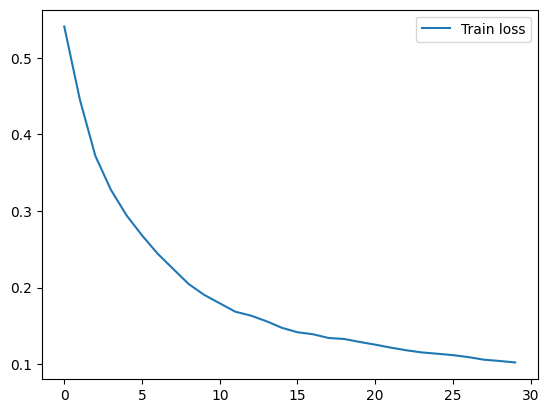

초기 Accuracy: 0.8624
초기 F1 Score: 0.9037
변경 후 Accuracy: 0.9582
변경 후 F1 Score: 0.9703


In [50]:
best_model = create_model(dropout_rate=grid_result.best_params_['dropout_rate'], activation=grid_result.best_params_['activation'])
history = best_model.fit(X_train_full, y_train_full, epochs=epochs, batch_size=grid_result.best_params_['batch_size'])

y_pred = best_model.predict(X_test)
y_pred_class = (y_pred > 0.5).astype("int32")

plt.figure()
plt.plot(history.history['loss'], label='Train loss')
plt.legend()
plt.show()

accuracy = accuracy_score(y_test, y_pred_class)
f1 = f1_score(y_test, y_pred_class)

print(f'초기 Accuracy: {init_accuracy:.4f}')
print(f'초기 F1 Score: {init_f1:.4f}')
print(f'변경 후 Accuracy: {accuracy:.4f}')
print(f'변경 후 F1 Score: {f1:.4f}')

In [51]:
def create_model(base_size=64, optimizer='Adam'):
    model = Sequential()
    model.add(Dense(base_size*4, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(0.1))
    model.add(Dense(base_size*2, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [52]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

set_seed()

batch_size = 1024
epochs = 30
base_size = 64
optimizer = 'adam'

X_train_full = np.concatenate((X_train, X_valid), axis=0)
y_train_full = np.concatenate((y_train, y_valid), axis=0)

model = KerasClassifier(build_fn=create_model, base_size=base_size, optimizer=optimizer, epochs=epochs, batch_size=batch_size, verbose=0)

param_grid = {
    'base_size': [32, 64, 128],
    'optimizer': ['adam', 'SGD', 'RMSprop']
}

grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid_result = grid.fit(X_train_full, y_train_full)

c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_d

In [53]:
print(f'Best: {grid_result.best_score_} using {grid_result.best_params_}')

Best: 0.9487475836072647 using {'base_size': 128, 'optimizer': 'adam'}


Epoch 1/30


c:\Users\user\anaconda3\envs\hngv_venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7144 - loss: 0.5591
Epoch 2/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7921 - loss: 0.4083
Epoch 3/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8341 - loss: 0.3418
Epoch 4/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8586 - loss: 0.3012
Epoch 5/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8752 - loss: 0.2655 
Epoch 6/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8886 - loss: 0.2357
Epoch 7/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9024 - loss: 0.2087
Epoch 8/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9153 - loss: 0.1857
Epoch 9/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9234 - loss: 0.1705
Epoch 10/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9273 - loss: 0.1582
Epoch 11/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9314 - loss: 0.1527
Epoch 12/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9340 - l

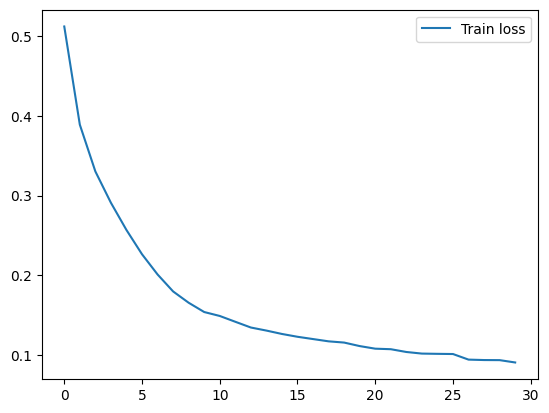

초기 Accuracy: 0.8624
초기 F1 Score: 0.9037
변경 후 Accuracy: 0.9632
변경 후 F1 Score: 0.9739


In [54]:
best_model = create_model(base_size=grid_result.best_params_['base_size'], optimizer=grid_result.best_params_['optimizer'])
history = best_model.fit(X_train_full, y_train_full, epochs=epochs, batch_size=batch_size)

y_pred = best_model.predict(X_test)
y_pred_class = (y_pred > 0.5).astype("int32")

plt.figure()
plt.plot(history.history['loss'], label='Train loss')
plt.legend()
plt.show()

accuracy = accuracy_score(y_test, y_pred_class)
f1 = f1_score(y_test, y_pred_class)

print(f'초기 Accuracy: {init_accuracy:.4f}')
print(f'초기 F1 Score: {init_f1:.4f}')
print(f'변경 후 Accuracy: {accuracy:.4f}')
print(f'변경 후 F1 Score: {f1:.4f}')